In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'full'

In [4]:
# Parameters
fs_type = "int95"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 135
Categorical features: 6
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0


Numerical Columns: 207
Categorical Columns: 6


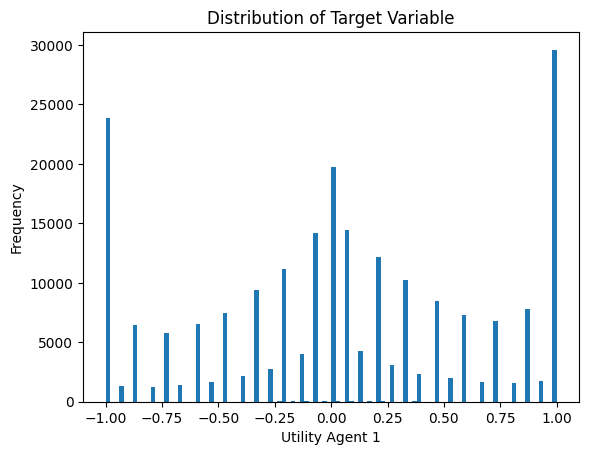

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6119576	test: 0.5479250	best: 0.5479250 (0)	total: 149ms	remaining: 7m 26s


50:	learn: 0.3814643	test: 0.4585339	best: 0.4585339 (50)	total: 3.99s	remaining: 3m 50s


100:	learn: 0.3415636	test: 0.4407061	best: 0.4407061 (100)	total: 7.9s	remaining: 3m 46s


150:	learn: 0.3212658	test: 0.4350495	best: 0.4350495 (150)	total: 11.9s	remaining: 3m 44s


200:	learn: 0.3064444	test: 0.4311837	best: 0.4311812 (199)	total: 15.9s	remaining: 3m 42s


250:	learn: 0.2954580	test: 0.4284824	best: 0.4284824 (250)	total: 19.9s	remaining: 3m 37s


300:	learn: 0.2858092	test: 0.4270238	best: 0.4269642 (294)	total: 23.9s	remaining: 3m 34s


350:	learn: 0.2785788	test: 0.4251706	best: 0.4251706 (350)	total: 27.9s	remaining: 3m 30s


400:	learn: 0.2719273	test: 0.4243868	best: 0.4243868 (400)	total: 31.9s	remaining: 3m 27s


450:	learn: 0.2659022	test: 0.4234246	best: 0.4234246 (450)	total: 36s	remaining: 3m 23s


500:	learn: 0.2607340	test: 0.4226154	best: 0.4225139 (495)	total: 40.1s	remaining: 3m 19s


550:	learn: 0.2559537	test: 0.4219203	best: 0.4218761 (549)	total: 44.1s	remaining: 3m 16s


600:	learn: 0.2514933	test: 0.4212374	best: 0.4212338 (599)	total: 48.2s	remaining: 3m 12s


650:	learn: 0.2474134	test: 0.4207536	best: 0.4207465 (648)	total: 52.2s	remaining: 3m 8s


700:	learn: 0.2431796	test: 0.4204520	best: 0.4203679 (699)	total: 56.3s	remaining: 3m 4s


750:	learn: 0.2395906	test: 0.4200842	best: 0.4200842 (750)	total: 1m	remaining: 3m


800:	learn: 0.2364941	test: 0.4199099	best: 0.4198987 (796)	total: 1m 4s	remaining: 2m 56s


850:	learn: 0.2333754	test: 0.4197688	best: 0.4197475 (847)	total: 1m 8s	remaining: 2m 52s


900:	learn: 0.2303703	test: 0.4196081	best: 0.4195757 (894)	total: 1m 12s	remaining: 2m 48s


950:	learn: 0.2276433	test: 0.4193296	best: 0.4193190 (949)	total: 1m 16s	remaining: 2m 44s


1000:	learn: 0.2250355	test: 0.4190460	best: 0.4190401 (994)	total: 1m 20s	remaining: 2m 40s


1050:	learn: 0.2223802	test: 0.4187206	best: 0.4187156 (1040)	total: 1m 24s	remaining: 2m 36s


1100:	learn: 0.2198653	test: 0.4188490	best: 0.4186597 (1060)	total: 1m 28s	remaining: 2m 32s


1150:	learn: 0.2173866	test: 0.4187317	best: 0.4186597 (1060)	total: 1m 32s	remaining: 2m 28s


1200:	learn: 0.2150652	test: 0.4187217	best: 0.4186597 (1060)	total: 1m 36s	remaining: 2m 24s


1250:	learn: 0.2130832	test: 0.4186430	best: 0.4186387 (1245)	total: 1m 40s	remaining: 2m 20s


1300:	learn: 0.2111896	test: 0.4184696	best: 0.4184651 (1298)	total: 1m 44s	remaining: 2m 16s


1350:	learn: 0.2090598	test: 0.4183505	best: 0.4183502 (1333)	total: 1m 48s	remaining: 2m 12s


1400:	learn: 0.2071665	test: 0.4182830	best: 0.4182594 (1389)	total: 1m 52s	remaining: 2m 8s


1450:	learn: 0.2053180	test: 0.4180822	best: 0.4180727 (1448)	total: 1m 56s	remaining: 2m 4s


1500:	learn: 0.2035122	test: 0.4179164	best: 0.4179164 (1500)	total: 2m	remaining: 2m


1550:	learn: 0.2017229	test: 0.4177936	best: 0.4177892 (1546)	total: 2m 4s	remaining: 1m 56s


1600:	learn: 0.2000232	test: 0.4177138	best: 0.4176799 (1596)	total: 2m 8s	remaining: 1m 52s


1650:	learn: 0.1984018	test: 0.4177935	best: 0.4176799 (1596)	total: 2m 12s	remaining: 1m 48s


1700:	learn: 0.1967776	test: 0.4177716	best: 0.4176799 (1596)	total: 2m 16s	remaining: 1m 44s


1750:	learn: 0.1952384	test: 0.4178103	best: 0.4176799 (1596)	total: 2m 20s	remaining: 1m 40s


1800:	learn: 0.1937229	test: 0.4177384	best: 0.4176799 (1596)	total: 2m 24s	remaining: 1m 36s


1850:	learn: 0.1921563	test: 0.4176560	best: 0.4176560 (1850)	total: 2m 28s	remaining: 1m 32s


1900:	learn: 0.1906630	test: 0.4177282	best: 0.4176160 (1855)	total: 2m 32s	remaining: 1m 28s


1950:	learn: 0.1891945	test: 0.4176699	best: 0.4176160 (1855)	total: 2m 36s	remaining: 1m 24s


2000:	learn: 0.1877730	test: 0.4176067	best: 0.4176039 (1989)	total: 2m 40s	remaining: 1m 20s


2050:	learn: 0.1862376	test: 0.4175627	best: 0.4175563 (2049)	total: 2m 44s	remaining: 1m 16s


2100:	learn: 0.1848812	test: 0.4175056	best: 0.4174938 (2098)	total: 2m 49s	remaining: 1m 12s


2150:	learn: 0.1835577	test: 0.4175223	best: 0.4174938 (2098)	total: 2m 53s	remaining: 1m 8s


2200:	learn: 0.1821836	test: 0.4174540	best: 0.4174540 (2200)	total: 2m 57s	remaining: 1m 4s


2250:	learn: 0.1806815	test: 0.4173932	best: 0.4173779 (2219)	total: 3m	remaining: 1m


2300:	learn: 0.1794259	test: 0.4173640	best: 0.4173450 (2295)	total: 3m 5s	remaining: 56.2s


2350:	learn: 0.1780186	test: 0.4173190	best: 0.4173190 (2350)	total: 3m 9s	remaining: 52.2s


2400:	learn: 0.1766624	test: 0.4173241	best: 0.4172908 (2389)	total: 3m 13s	remaining: 48.2s


2450:	learn: 0.1755010	test: 0.4172584	best: 0.4172584 (2450)	total: 3m 17s	remaining: 44.2s


2500:	learn: 0.1742173	test: 0.4173141	best: 0.4172584 (2450)	total: 3m 21s	remaining: 40.1s


2550:	learn: 0.1731251	test: 0.4173062	best: 0.4172584 (2450)	total: 3m 25s	remaining: 36.1s


2600:	learn: 0.1720434	test: 0.4173330	best: 0.4172584 (2450)	total: 3m 29s	remaining: 32.1s


2650:	learn: 0.1708250	test: 0.4173939	best: 0.4172584 (2450)	total: 3m 33s	remaining: 28.1s


2700:	learn: 0.1696544	test: 0.4173844	best: 0.4172584 (2450)	total: 3m 37s	remaining: 24.1s


2750:	learn: 0.1685326	test: 0.4173903	best: 0.4172584 (2450)	total: 3m 41s	remaining: 20s


2800:	learn: 0.1674750	test: 0.4173355	best: 0.4172584 (2450)	total: 3m 45s	remaining: 16s


2850:	learn: 0.1663746	test: 0.4173761	best: 0.4172584 (2450)	total: 3m 49s	remaining: 12s


2900:	learn: 0.1653506	test: 0.4173085	best: 0.4172584 (2450)	total: 3m 53s	remaining: 7.97s


2950:	learn: 0.1643953	test: 0.4173447	best: 0.4172584 (2450)	total: 3m 57s	remaining: 3.95s


2999:	learn: 0.1633810	test: 0.4173769	best: 0.4172584 (2450)	total: 4m 1s	remaining: 0us

bestTest = 0.4172583958
bestIteration = 2450

Shrink model to first 2451 iterations.


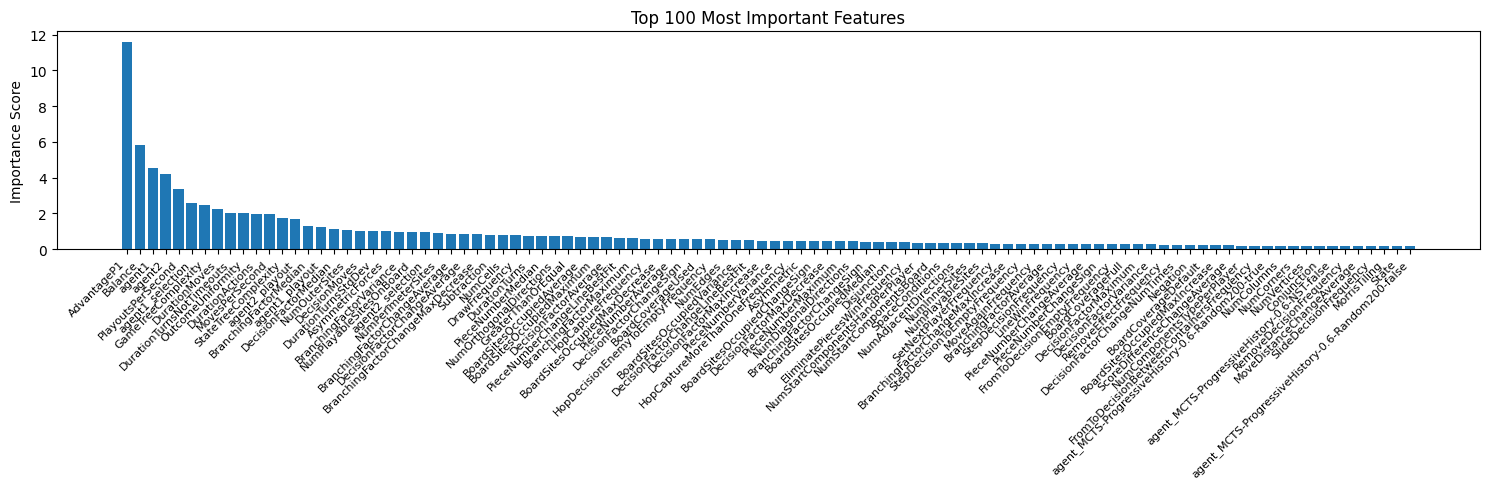

Fold 1 - RMSE: 0.4168401062756963
Fold 2


0:	learn: 0.6057844	test: 0.5787583	best: 0.5787583 (0)	total: 67.6ms	remaining: 3m 22s


50:	learn: 0.3891734	test: 0.4864868	best: 0.4864868 (50)	total: 3.86s	remaining: 3m 43s


100:	learn: 0.3507073	test: 0.4730564	best: 0.4729857 (99)	total: 7.9s	remaining: 3m 46s


150:	learn: 0.3284653	test: 0.4666236	best: 0.4665603 (149)	total: 12s	remaining: 3m 47s


200:	learn: 0.3143415	test: 0.4631442	best: 0.4631442 (200)	total: 16.1s	remaining: 3m 44s


250:	learn: 0.3034930	test: 0.4608955	best: 0.4607677 (247)	total: 20.2s	remaining: 3m 41s


300:	learn: 0.2933561	test: 0.4596718	best: 0.4596718 (300)	total: 24.3s	remaining: 3m 38s


350:	learn: 0.2850120	test: 0.4585067	best: 0.4585067 (350)	total: 28.4s	remaining: 3m 34s


400:	learn: 0.2784712	test: 0.4577338	best: 0.4577338 (400)	total: 32.5s	remaining: 3m 30s


450:	learn: 0.2725025	test: 0.4568787	best: 0.4568167 (447)	total: 36.6s	remaining: 3m 26s


500:	learn: 0.2672064	test: 0.4561793	best: 0.4561793 (500)	total: 40.7s	remaining: 3m 23s


550:	learn: 0.2623387	test: 0.4556676	best: 0.4556676 (550)	total: 44.8s	remaining: 3m 19s


600:	learn: 0.2579719	test: 0.4551716	best: 0.4551716 (600)	total: 49.1s	remaining: 3m 15s


650:	learn: 0.2536991	test: 0.4548393	best: 0.4548393 (650)	total: 53.2s	remaining: 3m 11s


700:	learn: 0.2501493	test: 0.4541485	best: 0.4541485 (700)	total: 57.5s	remaining: 3m 8s


750:	learn: 0.2464946	test: 0.4538148	best: 0.4538148 (750)	total: 1m 1s	remaining: 3m 4s


800:	learn: 0.2431731	test: 0.4534474	best: 0.4534410 (798)	total: 1m 5s	remaining: 3m


850:	learn: 0.2397593	test: 0.4529861	best: 0.4529501 (843)	total: 1m 9s	remaining: 2m 56s


900:	learn: 0.2369253	test: 0.4527655	best: 0.4527645 (890)	total: 1m 14s	remaining: 2m 52s


950:	learn: 0.2341850	test: 0.4526245	best: 0.4525776 (940)	total: 1m 18s	remaining: 2m 48s


1000:	learn: 0.2315549	test: 0.4522845	best: 0.4522455 (984)	total: 1m 22s	remaining: 2m 45s


1050:	learn: 0.2290598	test: 0.4520569	best: 0.4520569 (1050)	total: 1m 26s	remaining: 2m 41s


1100:	learn: 0.2267035	test: 0.4518391	best: 0.4518391 (1100)	total: 1m 31s	remaining: 2m 36s


1150:	learn: 0.2242882	test: 0.4516301	best: 0.4516264 (1148)	total: 1m 35s	remaining: 2m 32s


1200:	learn: 0.2221755	test: 0.4515607	best: 0.4515607 (1200)	total: 1m 39s	remaining: 2m 28s


1250:	learn: 0.2199814	test: 0.4516197	best: 0.4515470 (1223)	total: 1m 43s	remaining: 2m 24s


1300:	learn: 0.2178861	test: 0.4515974	best: 0.4515470 (1223)	total: 1m 47s	remaining: 2m 20s


1350:	learn: 0.2157704	test: 0.4514614	best: 0.4514547 (1343)	total: 1m 52s	remaining: 2m 16s


1400:	learn: 0.2138506	test: 0.4514624	best: 0.4514448 (1390)	total: 1m 56s	remaining: 2m 12s


1450:	learn: 0.2119699	test: 0.4514100	best: 0.4514045 (1449)	total: 2m	remaining: 2m 8s


1500:	learn: 0.2102095	test: 0.4513645	best: 0.4513399 (1472)	total: 2m 4s	remaining: 2m 4s


1550:	learn: 0.2085140	test: 0.4513170	best: 0.4513083 (1543)	total: 2m 9s	remaining: 2m


1600:	learn: 0.2067249	test: 0.4511252	best: 0.4511252 (1600)	total: 2m 13s	remaining: 1m 56s


1650:	learn: 0.2050901	test: 0.4512512	best: 0.4511252 (1600)	total: 2m 17s	remaining: 1m 52s


1700:	learn: 0.2033981	test: 0.4511470	best: 0.4511252 (1600)	total: 2m 21s	remaining: 1m 48s


1750:	learn: 0.2018127	test: 0.4510927	best: 0.4510779 (1719)	total: 2m 26s	remaining: 1m 44s


1800:	learn: 0.2002169	test: 0.4509271	best: 0.4509158 (1799)	total: 2m 30s	remaining: 1m 40s


1850:	learn: 0.1986887	test: 0.4509240	best: 0.4508774 (1818)	total: 2m 34s	remaining: 1m 35s


1900:	learn: 0.1971941	test: 0.4509058	best: 0.4508774 (1818)	total: 2m 38s	remaining: 1m 31s


1950:	learn: 0.1955973	test: 0.4508445	best: 0.4508294 (1945)	total: 2m 43s	remaining: 1m 27s


2000:	learn: 0.1941515	test: 0.4508099	best: 0.4507844 (1987)	total: 2m 47s	remaining: 1m 23s


2050:	learn: 0.1927843	test: 0.4507361	best: 0.4507272 (2049)	total: 2m 51s	remaining: 1m 19s


2100:	learn: 0.1914172	test: 0.4506848	best: 0.4506655 (2093)	total: 2m 55s	remaining: 1m 15s


2150:	learn: 0.1900605	test: 0.4506928	best: 0.4506655 (2093)	total: 2m 59s	remaining: 1m 10s


2200:	learn: 0.1886289	test: 0.4507439	best: 0.4506655 (2093)	total: 3m 4s	remaining: 1m 6s


2250:	learn: 0.1872685	test: 0.4507407	best: 0.4506655 (2093)	total: 3m 8s	remaining: 1m 2s


2300:	learn: 0.1859215	test: 0.4506853	best: 0.4506655 (2093)	total: 3m 12s	remaining: 58.4s


2350:	learn: 0.1847407	test: 0.4507327	best: 0.4506655 (2093)	total: 3m 16s	remaining: 54.3s


2400:	learn: 0.1835626	test: 0.4507091	best: 0.4506655 (2093)	total: 3m 20s	remaining: 50.1s


2450:	learn: 0.1823309	test: 0.4507217	best: 0.4506639 (2427)	total: 3m 24s	remaining: 45.9s


2500:	learn: 0.1811115	test: 0.4507578	best: 0.4506639 (2427)	total: 3m 29s	remaining: 41.7s


2550:	learn: 0.1798348	test: 0.4507699	best: 0.4506639 (2427)	total: 3m 33s	remaining: 37.6s


2600:	learn: 0.1786520	test: 0.4507129	best: 0.4506639 (2427)	total: 3m 37s	remaining: 33.4s


2650:	learn: 0.1775510	test: 0.4506982	best: 0.4506639 (2427)	total: 3m 41s	remaining: 29.2s


2700:	learn: 0.1764194	test: 0.4507141	best: 0.4506639 (2427)	total: 3m 46s	remaining: 25s


2750:	learn: 0.1753066	test: 0.4506298	best: 0.4506190 (2740)	total: 3m 50s	remaining: 20.8s


2800:	learn: 0.1741214	test: 0.4506254	best: 0.4506043 (2787)	total: 3m 54s	remaining: 16.7s


2850:	learn: 0.1729571	test: 0.4507091	best: 0.4506043 (2787)	total: 3m 58s	remaining: 12.5s


2900:	learn: 0.1718919	test: 0.4506576	best: 0.4506043 (2787)	total: 4m 2s	remaining: 8.29s


2950:	learn: 0.1708793	test: 0.4506812	best: 0.4506043 (2787)	total: 4m 7s	remaining: 4.1s


2999:	learn: 0.1698209	test: 0.4506906	best: 0.4506043 (2787)	total: 4m 11s	remaining: 0us

bestTest = 0.4506043286
bestIteration = 2787

Shrink model to first 2788 iterations.


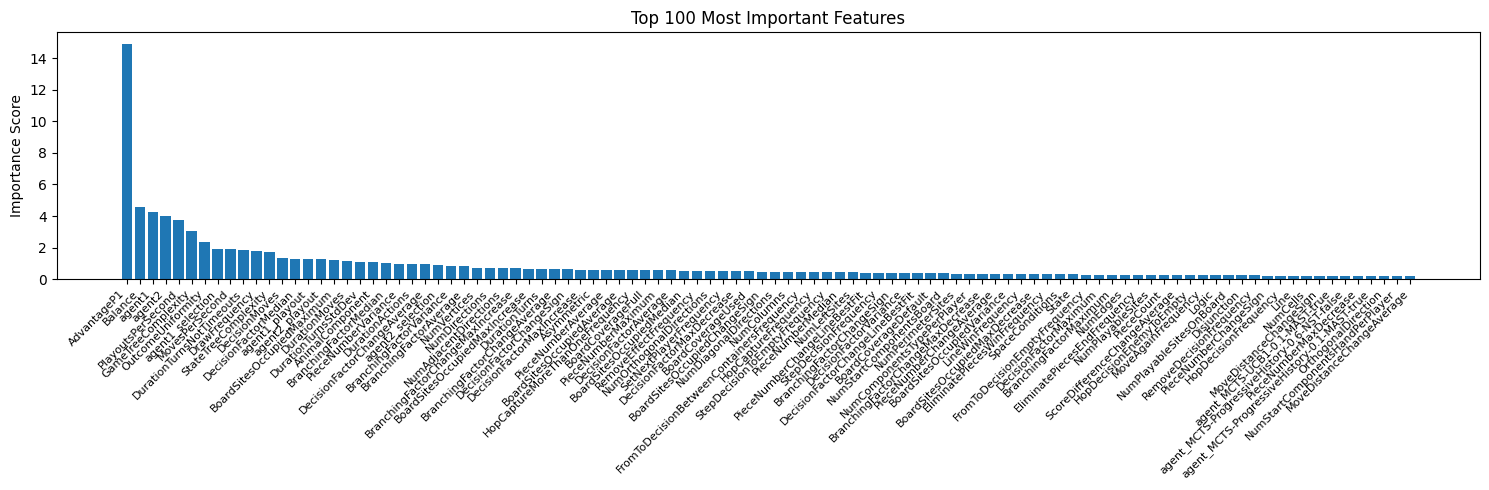

Fold 2 - RMSE: 0.4502203894189077
Fold 3


0:	learn: 0.6028070	test: 0.5989821	best: 0.5989821 (0)	total: 73.3ms	remaining: 3m 39s


50:	learn: 0.3873354	test: 0.4718037	best: 0.4718037 (50)	total: 3.9s	remaining: 3m 45s


100:	learn: 0.3492081	test: 0.4545859	best: 0.4545859 (100)	total: 7.96s	remaining: 3m 48s


150:	learn: 0.3286406	test: 0.4478647	best: 0.4478647 (150)	total: 12.1s	remaining: 3m 47s


200:	learn: 0.3136882	test: 0.4443677	best: 0.4443677 (200)	total: 16s	remaining: 3m 43s


250:	learn: 0.3017653	test: 0.4419313	best: 0.4419313 (250)	total: 20.1s	remaining: 3m 39s


300:	learn: 0.2926581	test: 0.4402294	best: 0.4402294 (300)	total: 24.1s	remaining: 3m 35s


350:	learn: 0.2844459	test: 0.4388142	best: 0.4386227 (346)	total: 28.2s	remaining: 3m 32s


400:	learn: 0.2779029	test: 0.4377620	best: 0.4377571 (399)	total: 32.3s	remaining: 3m 29s


450:	learn: 0.2720740	test: 0.4371622	best: 0.4371622 (450)	total: 36.3s	remaining: 3m 25s


500:	learn: 0.2661896	test: 0.4366772	best: 0.4366772 (500)	total: 40.4s	remaining: 3m 21s


550:	learn: 0.2612972	test: 0.4361967	best: 0.4361967 (550)	total: 44.5s	remaining: 3m 17s


600:	learn: 0.2566617	test: 0.4355473	best: 0.4355359 (599)	total: 48.7s	remaining: 3m 14s


650:	learn: 0.2524666	test: 0.4351076	best: 0.4351076 (650)	total: 52.7s	remaining: 3m 10s


700:	learn: 0.2482626	test: 0.4346570	best: 0.4346570 (700)	total: 56.9s	remaining: 3m 6s


750:	learn: 0.2447891	test: 0.4345375	best: 0.4345375 (750)	total: 1m 1s	remaining: 3m 2s


800:	learn: 0.2415183	test: 0.4340331	best: 0.4340327 (795)	total: 1m 5s	remaining: 2m 59s


850:	learn: 0.2385186	test: 0.4337609	best: 0.4337284 (840)	total: 1m 9s	remaining: 2m 55s


900:	learn: 0.2354826	test: 0.4336825	best: 0.4336665 (896)	total: 1m 13s	remaining: 2m 51s


950:	learn: 0.2327671	test: 0.4334010	best: 0.4333614 (941)	total: 1m 17s	remaining: 2m 47s


1000:	learn: 0.2302197	test: 0.4331901	best: 0.4331901 (1000)	total: 1m 21s	remaining: 2m 42s


1050:	learn: 0.2276792	test: 0.4329635	best: 0.4329635 (1050)	total: 1m 25s	remaining: 2m 39s


1100:	learn: 0.2251864	test: 0.4329136	best: 0.4328717 (1095)	total: 1m 29s	remaining: 2m 35s


1150:	learn: 0.2227828	test: 0.4326914	best: 0.4326914 (1150)	total: 1m 33s	remaining: 2m 30s


1200:	learn: 0.2205522	test: 0.4326802	best: 0.4326267 (1186)	total: 1m 38s	remaining: 2m 26s


1250:	learn: 0.2183618	test: 0.4325421	best: 0.4325421 (1250)	total: 1m 42s	remaining: 2m 22s


1300:	learn: 0.2162930	test: 0.4324512	best: 0.4324398 (1298)	total: 1m 46s	remaining: 2m 18s


1350:	learn: 0.2143092	test: 0.4324335	best: 0.4323717 (1323)	total: 1m 50s	remaining: 2m 14s


1400:	learn: 0.2124184	test: 0.4322681	best: 0.4322671 (1399)	total: 1m 54s	remaining: 2m 10s


1450:	learn: 0.2105397	test: 0.4321698	best: 0.4321645 (1449)	total: 1m 58s	remaining: 2m 6s


1500:	learn: 0.2087965	test: 0.4321992	best: 0.4321389 (1471)	total: 2m 2s	remaining: 2m 2s


1550:	learn: 0.2069956	test: 0.4321494	best: 0.4321231 (1542)	total: 2m 7s	remaining: 1m 58s


1600:	learn: 0.2053226	test: 0.4321367	best: 0.4321231 (1542)	total: 2m 11s	remaining: 1m 54s


1650:	learn: 0.2033829	test: 0.4320736	best: 0.4320736 (1650)	total: 2m 15s	remaining: 1m 50s


1700:	learn: 0.2017235	test: 0.4318741	best: 0.4318721 (1699)	total: 2m 19s	remaining: 1m 46s


1750:	learn: 0.2000721	test: 0.4319427	best: 0.4318548 (1702)	total: 2m 23s	remaining: 1m 42s


1800:	learn: 0.1985031	test: 0.4319250	best: 0.4318548 (1702)	total: 2m 27s	remaining: 1m 38s


1850:	learn: 0.1968866	test: 0.4318988	best: 0.4318548 (1702)	total: 2m 31s	remaining: 1m 34s


1900:	learn: 0.1953158	test: 0.4318683	best: 0.4318073 (1876)	total: 2m 36s	remaining: 1m 30s


1950:	learn: 0.1938379	test: 0.4317886	best: 0.4317776 (1947)	total: 2m 40s	remaining: 1m 26s


2000:	learn: 0.1924567	test: 0.4317613	best: 0.4317129 (1956)	total: 2m 44s	remaining: 1m 22s


2050:	learn: 0.1911227	test: 0.4317522	best: 0.4317129 (1956)	total: 2m 48s	remaining: 1m 18s


2100:	learn: 0.1897386	test: 0.4317601	best: 0.4317129 (1956)	total: 2m 52s	remaining: 1m 13s


2150:	learn: 0.1883949	test: 0.4317293	best: 0.4317129 (1956)	total: 2m 56s	remaining: 1m 9s


2200:	learn: 0.1872027	test: 0.4316496	best: 0.4316419 (2199)	total: 3m 1s	remaining: 1m 5s


2250:	learn: 0.1858938	test: 0.4316224	best: 0.4315897 (2217)	total: 3m 5s	remaining: 1m 1s


2300:	learn: 0.1845292	test: 0.4316532	best: 0.4315897 (2217)	total: 3m 9s	remaining: 57.6s


2350:	learn: 0.1831009	test: 0.4315612	best: 0.4315518 (2347)	total: 3m 13s	remaining: 53.5s


2400:	learn: 0.1818126	test: 0.4316434	best: 0.4315518 (2347)	total: 3m 17s	remaining: 49.4s


2450:	learn: 0.1805580	test: 0.4316194	best: 0.4315518 (2347)	total: 3m 22s	remaining: 45.3s


2500:	learn: 0.1793944	test: 0.4316610	best: 0.4315518 (2347)	total: 3m 26s	remaining: 41.2s


2550:	learn: 0.1781717	test: 0.4316655	best: 0.4315518 (2347)	total: 3m 30s	remaining: 37.1s


2600:	learn: 0.1769301	test: 0.4317134	best: 0.4315518 (2347)	total: 3m 34s	remaining: 32.9s


2650:	learn: 0.1757395	test: 0.4316379	best: 0.4315518 (2347)	total: 3m 38s	remaining: 28.8s


2700:	learn: 0.1745377	test: 0.4316158	best: 0.4315518 (2347)	total: 3m 42s	remaining: 24.7s


2750:	learn: 0.1734427	test: 0.4316236	best: 0.4315518 (2347)	total: 3m 47s	remaining: 20.6s


2800:	learn: 0.1722792	test: 0.4316596	best: 0.4315518 (2347)	total: 3m 51s	remaining: 16.4s


2850:	learn: 0.1710954	test: 0.4316535	best: 0.4315518 (2347)	total: 3m 55s	remaining: 12.3s


2900:	learn: 0.1700816	test: 0.4316681	best: 0.4315518 (2347)	total: 3m 59s	remaining: 8.18s


2950:	learn: 0.1689416	test: 0.4316757	best: 0.4315518 (2347)	total: 4m 3s	remaining: 4.05s


2999:	learn: 0.1679455	test: 0.4316595	best: 0.4315518 (2347)	total: 4m 7s	remaining: 0us

bestTest = 0.4315517862
bestIteration = 2347

Shrink model to first 2348 iterations.


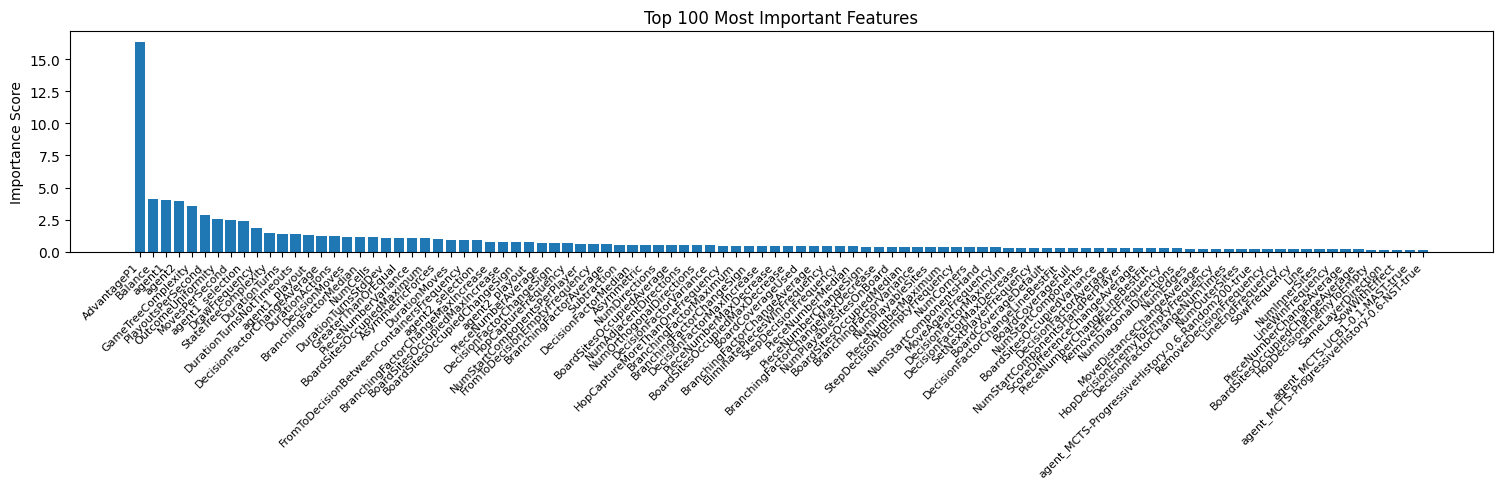

Fold 3 - RMSE: 0.4308232416262284
Fold 4


0:	learn: 0.6027134	test: 0.5904553	best: 0.5904553 (0)	total: 69.8ms	remaining: 3m 29s


50:	learn: 0.3869669	test: 0.4819999	best: 0.4819999 (50)	total: 3.91s	remaining: 3m 45s


100:	learn: 0.3483462	test: 0.4623101	best: 0.4623101 (100)	total: 7.93s	remaining: 3m 47s


150:	learn: 0.3267449	test: 0.4545034	best: 0.4545034 (150)	total: 12s	remaining: 3m 47s


200:	learn: 0.3106744	test: 0.4511536	best: 0.4511536 (200)	total: 16.1s	remaining: 3m 43s


250:	learn: 0.2998435	test: 0.4492053	best: 0.4491821 (247)	total: 20.1s	remaining: 3m 40s


300:	learn: 0.2908152	test: 0.4472231	best: 0.4472231 (300)	total: 24.2s	remaining: 3m 36s


350:	learn: 0.2834246	test: 0.4458284	best: 0.4458116 (348)	total: 28.3s	remaining: 3m 33s


400:	learn: 0.2762904	test: 0.4446823	best: 0.4446823 (400)	total: 32.3s	remaining: 3m 29s


450:	learn: 0.2701303	test: 0.4440606	best: 0.4440526 (446)	total: 36.4s	remaining: 3m 25s


500:	learn: 0.2643940	test: 0.4430887	best: 0.4430887 (500)	total: 40.5s	remaining: 3m 22s


550:	learn: 0.2594841	test: 0.4427121	best: 0.4427121 (550)	total: 44.6s	remaining: 3m 18s


600:	learn: 0.2547998	test: 0.4419885	best: 0.4419885 (600)	total: 48.8s	remaining: 3m 14s


650:	learn: 0.2505145	test: 0.4413214	best: 0.4413071 (647)	total: 52.8s	remaining: 3m 10s


700:	learn: 0.2464565	test: 0.4410665	best: 0.4410558 (699)	total: 56.8s	remaining: 3m 6s


750:	learn: 0.2430708	test: 0.4407726	best: 0.4407620 (749)	total: 1m	remaining: 3m 2s


800:	learn: 0.2397679	test: 0.4405655	best: 0.4405184 (785)	total: 1m 4s	remaining: 2m 58s


850:	learn: 0.2364807	test: 0.4402469	best: 0.4402469 (850)	total: 1m 8s	remaining: 2m 54s


900:	learn: 0.2338840	test: 0.4399467	best: 0.4399467 (900)	total: 1m 13s	remaining: 2m 50s


950:	learn: 0.2311176	test: 0.4396758	best: 0.4396739 (949)	total: 1m 17s	remaining: 2m 46s


1000:	learn: 0.2284397	test: 0.4393865	best: 0.4393833 (994)	total: 1m 21s	remaining: 2m 42s


1050:	learn: 0.2259614	test: 0.4393501	best: 0.4393485 (1011)	total: 1m 25s	remaining: 2m 38s


1100:	learn: 0.2234754	test: 0.4392548	best: 0.4392225 (1096)	total: 1m 29s	remaining: 2m 34s


1150:	learn: 0.2208363	test: 0.4390604	best: 0.4390567 (1141)	total: 1m 33s	remaining: 2m 30s


1200:	learn: 0.2187764	test: 0.4388801	best: 0.4388652 (1185)	total: 1m 37s	remaining: 2m 26s


1250:	learn: 0.2167325	test: 0.4387445	best: 0.4387363 (1216)	total: 1m 41s	remaining: 2m 22s


1300:	learn: 0.2145399	test: 0.4386729	best: 0.4386671 (1257)	total: 1m 45s	remaining: 2m 18s


1350:	learn: 0.2125270	test: 0.4384828	best: 0.4384668 (1349)	total: 1m 49s	remaining: 2m 14s


1400:	learn: 0.2105215	test: 0.4384081	best: 0.4383603 (1374)	total: 1m 54s	remaining: 2m 10s


1450:	learn: 0.2085721	test: 0.4383135	best: 0.4383060 (1448)	total: 1m 58s	remaining: 2m 5s


1500:	learn: 0.2067648	test: 0.4382559	best: 0.4382554 (1486)	total: 2m 2s	remaining: 2m 1s


1550:	learn: 0.2049215	test: 0.4381646	best: 0.4381473 (1545)	total: 2m 6s	remaining: 1m 57s


1600:	learn: 0.2031102	test: 0.4381677	best: 0.4381473 (1545)	total: 2m 10s	remaining: 1m 53s


1650:	learn: 0.2014122	test: 0.4381741	best: 0.4381247 (1619)	total: 2m 14s	remaining: 1m 49s


1700:	learn: 0.1997957	test: 0.4381750	best: 0.4381247 (1619)	total: 2m 18s	remaining: 1m 45s


1750:	learn: 0.1982197	test: 0.4381041	best: 0.4381041 (1750)	total: 2m 22s	remaining: 1m 41s


1800:	learn: 0.1966275	test: 0.4381470	best: 0.4380998 (1764)	total: 2m 26s	remaining: 1m 37s


1850:	learn: 0.1952126	test: 0.4381160	best: 0.4380998 (1764)	total: 2m 31s	remaining: 1m 33s


1900:	learn: 0.1936580	test: 0.4380804	best: 0.4380366 (1890)	total: 2m 35s	remaining: 1m 29s


1950:	learn: 0.1921495	test: 0.4379770	best: 0.4379770 (1950)	total: 2m 39s	remaining: 1m 25s


2000:	learn: 0.1907909	test: 0.4380215	best: 0.4379728 (1959)	total: 2m 43s	remaining: 1m 21s


2050:	learn: 0.1893451	test: 0.4379809	best: 0.4379302 (2023)	total: 2m 47s	remaining: 1m 17s


2100:	learn: 0.1880013	test: 0.4379822	best: 0.4379302 (2023)	total: 2m 51s	remaining: 1m 13s


2150:	learn: 0.1866991	test: 0.4379999	best: 0.4379302 (2023)	total: 2m 55s	remaining: 1m 9s


2200:	learn: 0.1853886	test: 0.4379945	best: 0.4379302 (2023)	total: 2m 59s	remaining: 1m 5s


2250:	learn: 0.1840530	test: 0.4379477	best: 0.4379292 (2237)	total: 3m 4s	remaining: 1m 1s


2300:	learn: 0.1827707	test: 0.4379425	best: 0.4379292 (2237)	total: 3m 8s	remaining: 57.2s


2350:	learn: 0.1814492	test: 0.4379240	best: 0.4379078 (2346)	total: 3m 12s	remaining: 53.1s


2400:	learn: 0.1803043	test: 0.4379751	best: 0.4379078 (2346)	total: 3m 16s	remaining: 49s


2450:	learn: 0.1791607	test: 0.4379849	best: 0.4379078 (2346)	total: 3m 20s	remaining: 44.9s


2500:	learn: 0.1780422	test: 0.4379633	best: 0.4379078 (2346)	total: 3m 24s	remaining: 40.9s


2550:	learn: 0.1768318	test: 0.4379502	best: 0.4379078 (2346)	total: 3m 28s	remaining: 36.8s


2600:	learn: 0.1756937	test: 0.4379569	best: 0.4379078 (2346)	total: 3m 33s	remaining: 32.7s


2650:	learn: 0.1745229	test: 0.4379686	best: 0.4379078 (2346)	total: 3m 37s	remaining: 28.6s


2700:	learn: 0.1733306	test: 0.4379908	best: 0.4379078 (2346)	total: 3m 41s	remaining: 24.5s


2750:	learn: 0.1722402	test: 0.4379726	best: 0.4379078 (2346)	total: 3m 45s	remaining: 20.4s


2800:	learn: 0.1710983	test: 0.4379269	best: 0.4379078 (2346)	total: 3m 49s	remaining: 16.3s


2850:	learn: 0.1699630	test: 0.4379763	best: 0.4379078 (2346)	total: 3m 53s	remaining: 12.2s


2900:	learn: 0.1688905	test: 0.4379682	best: 0.4379078 (2346)	total: 3m 57s	remaining: 8.12s


2950:	learn: 0.1678921	test: 0.4379081	best: 0.4379078 (2346)	total: 4m 2s	remaining: 4.02s


2999:	learn: 0.1668449	test: 0.4379064	best: 0.4378849 (2960)	total: 4m 6s	remaining: 0us

bestTest = 0.4378849403
bestIteration = 2960

Shrink model to first 2961 iterations.


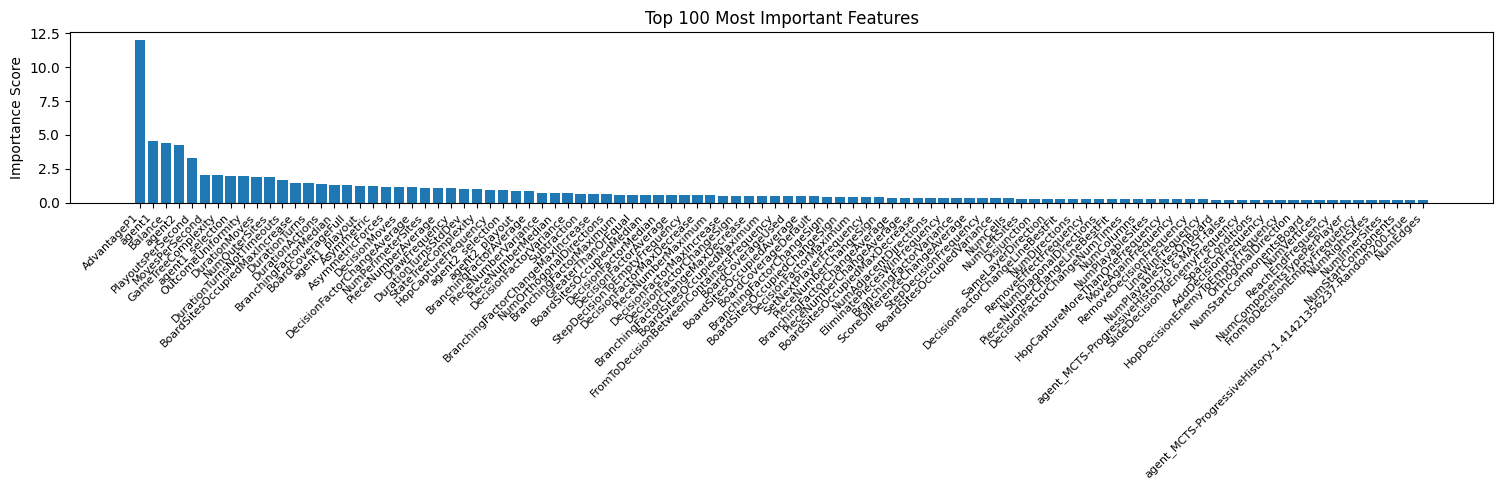

Fold 4 - RMSE: 0.4373144251015079
Fold 5


0:	learn: 0.6168427	test: 0.5417563	best: 0.5417563 (0)	total: 66ms	remaining: 3m 17s


50:	learn: 0.3943596	test: 0.4463338	best: 0.4463338 (50)	total: 3.84s	remaining: 3m 42s


100:	learn: 0.3548616	test: 0.4266440	best: 0.4266440 (100)	total: 7.83s	remaining: 3m 44s


150:	learn: 0.3326634	test: 0.4188165	best: 0.4188165 (150)	total: 11.7s	remaining: 3m 41s


200:	learn: 0.3176297	test: 0.4144872	best: 0.4144872 (200)	total: 15.7s	remaining: 3m 38s


250:	learn: 0.3059815	test: 0.4107377	best: 0.4107377 (250)	total: 19.7s	remaining: 3m 35s


300:	learn: 0.2955450	test: 0.4085617	best: 0.4085617 (300)	total: 23.7s	remaining: 3m 32s


350:	learn: 0.2876238	test: 0.4074196	best: 0.4073861 (348)	total: 27.7s	remaining: 3m 29s


400:	learn: 0.2809767	test: 0.4063316	best: 0.4063316 (400)	total: 31.8s	remaining: 3m 25s


450:	learn: 0.2743149	test: 0.4052347	best: 0.4052347 (450)	total: 35.7s	remaining: 3m 21s


500:	learn: 0.2686461	test: 0.4047935	best: 0.4047935 (500)	total: 39.7s	remaining: 3m 18s


550:	learn: 0.2638228	test: 0.4043312	best: 0.4043005 (547)	total: 43.7s	remaining: 3m 14s


600:	learn: 0.2594366	test: 0.4039084	best: 0.4038832 (593)	total: 47.6s	remaining: 3m 10s


650:	learn: 0.2554574	test: 0.4031930	best: 0.4031930 (650)	total: 51.7s	remaining: 3m 6s


700:	learn: 0.2513145	test: 0.4025091	best: 0.4025091 (700)	total: 55.8s	remaining: 3m 2s


750:	learn: 0.2476969	test: 0.4024844	best: 0.4022886 (727)	total: 59.7s	remaining: 2m 58s


800:	learn: 0.2445820	test: 0.4022030	best: 0.4021740 (798)	total: 1m 3s	remaining: 2m 55s


850:	learn: 0.2414043	test: 0.4019620	best: 0.4019389 (848)	total: 1m 7s	remaining: 2m 51s


900:	learn: 0.2382208	test: 0.4016100	best: 0.4016100 (900)	total: 1m 12s	remaining: 2m 47s


950:	learn: 0.2354638	test: 0.4016236	best: 0.4015281 (916)	total: 1m 16s	remaining: 2m 43s


1000:	learn: 0.2325423	test: 0.4014239	best: 0.4014239 (1000)	total: 1m 20s	remaining: 2m 40s


1050:	learn: 0.2297168	test: 0.4013135	best: 0.4012859 (1035)	total: 1m 24s	remaining: 2m 36s


1100:	learn: 0.2271578	test: 0.4009348	best: 0.4009340 (1089)	total: 1m 28s	remaining: 2m 32s


1150:	learn: 0.2247529	test: 0.4006790	best: 0.4006699 (1149)	total: 1m 32s	remaining: 2m 28s


1200:	learn: 0.2223491	test: 0.4007400	best: 0.4006081 (1163)	total: 1m 36s	remaining: 2m 24s


1250:	learn: 0.2201513	test: 0.4007281	best: 0.4006081 (1163)	total: 1m 40s	remaining: 2m 20s


1300:	learn: 0.2178549	test: 0.4007076	best: 0.4006081 (1163)	total: 1m 44s	remaining: 2m 16s


1350:	learn: 0.2158194	test: 0.4007379	best: 0.4006081 (1163)	total: 1m 48s	remaining: 2m 12s


1400:	learn: 0.2137441	test: 0.4007355	best: 0.4006081 (1163)	total: 1m 52s	remaining: 2m 8s


1450:	learn: 0.2116913	test: 0.4007312	best: 0.4006081 (1163)	total: 1m 56s	remaining: 2m 4s


1500:	learn: 0.2098071	test: 0.4007171	best: 0.4006081 (1163)	total: 2m	remaining: 2m


1550:	learn: 0.2079892	test: 0.4005829	best: 0.4005647 (1537)	total: 2m 4s	remaining: 1m 56s


1600:	learn: 0.2060830	test: 0.4005107	best: 0.4004928 (1583)	total: 2m 8s	remaining: 1m 52s


1650:	learn: 0.2043845	test: 0.4003841	best: 0.4003790 (1649)	total: 2m 12s	remaining: 1m 48s


1700:	learn: 0.2026433	test: 0.4003257	best: 0.4003114 (1692)	total: 2m 16s	remaining: 1m 44s


1750:	learn: 0.2009070	test: 0.4003568	best: 0.4003098 (1734)	total: 2m 20s	remaining: 1m 40s


1800:	learn: 0.1991781	test: 0.4003675	best: 0.4002949 (1788)	total: 2m 24s	remaining: 1m 36s


1850:	learn: 0.1976008	test: 0.4002762	best: 0.4002762 (1850)	total: 2m 28s	remaining: 1m 32s


1900:	learn: 0.1961381	test: 0.4004395	best: 0.4002762 (1850)	total: 2m 33s	remaining: 1m 28s


1950:	learn: 0.1945339	test: 0.4003396	best: 0.4002762 (1850)	total: 2m 36s	remaining: 1m 24s


2000:	learn: 0.1930898	test: 0.4003025	best: 0.4002762 (1850)	total: 2m 41s	remaining: 1m 20s


2050:	learn: 0.1917008	test: 0.4002836	best: 0.4002728 (2043)	total: 2m 45s	remaining: 1m 16s


2100:	learn: 0.1903879	test: 0.4003503	best: 0.4002625 (2054)	total: 2m 49s	remaining: 1m 12s


2150:	learn: 0.1889612	test: 0.4003875	best: 0.4002625 (2054)	total: 2m 53s	remaining: 1m 8s


2200:	learn: 0.1873870	test: 0.4004200	best: 0.4002625 (2054)	total: 2m 57s	remaining: 1m 4s


2250:	learn: 0.1860289	test: 0.4004257	best: 0.4002625 (2054)	total: 3m 1s	remaining: 1m


2300:	learn: 0.1846141	test: 0.4003898	best: 0.4002625 (2054)	total: 3m 5s	remaining: 56.2s


2350:	learn: 0.1833541	test: 0.4003976	best: 0.4002625 (2054)	total: 3m 9s	remaining: 52.2s


2400:	learn: 0.1821101	test: 0.4002760	best: 0.4002625 (2054)	total: 3m 13s	remaining: 48.2s


2450:	learn: 0.1808046	test: 0.4002236	best: 0.4002209 (2449)	total: 3m 17s	remaining: 44.2s


2500:	learn: 0.1795042	test: 0.4002229	best: 0.4001873 (2461)	total: 3m 21s	remaining: 40.1s


2550:	learn: 0.1783341	test: 0.4001971	best: 0.4001719 (2503)	total: 3m 25s	remaining: 36.1s


2600:	learn: 0.1771231	test: 0.4001714	best: 0.4001714 (2600)	total: 3m 29s	remaining: 32.1s


2650:	learn: 0.1759685	test: 0.4001699	best: 0.4001484 (2605)	total: 3m 33s	remaining: 28.1s


2700:	learn: 0.1748007	test: 0.4001907	best: 0.4001484 (2605)	total: 3m 37s	remaining: 24.1s


2750:	learn: 0.1737566	test: 0.4002129	best: 0.4001484 (2605)	total: 3m 41s	remaining: 20.1s


2800:	learn: 0.1726750	test: 0.4001611	best: 0.4001484 (2605)	total: 3m 45s	remaining: 16s


2850:	learn: 0.1715888	test: 0.4001401	best: 0.4001401 (2850)	total: 3m 49s	remaining: 12s


2900:	learn: 0.1705278	test: 0.4001302	best: 0.4001230 (2858)	total: 3m 53s	remaining: 7.98s


2950:	learn: 0.1693534	test: 0.4001438	best: 0.4001230 (2858)	total: 3m 57s	remaining: 3.95s


2999:	learn: 0.1682871	test: 0.4001412	best: 0.4001230 (2858)	total: 4m 1s	remaining: 0us

bestTest = 0.4001229509
bestIteration = 2858

Shrink model to first 2859 iterations.


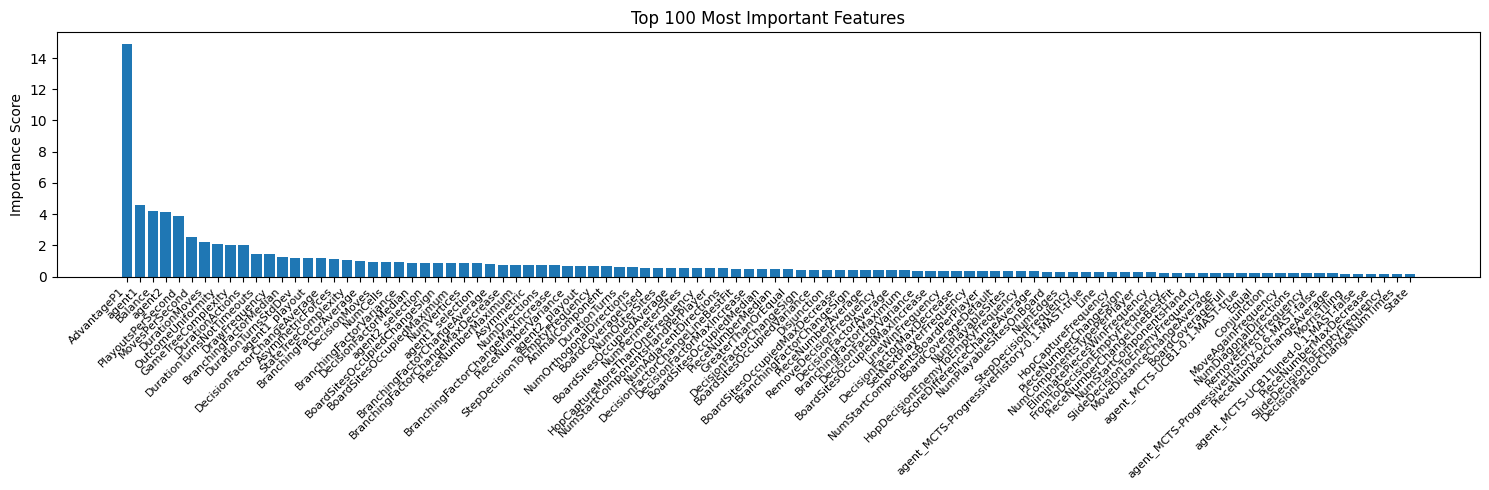

Fold 5 - RMSE: 0.3996677931908215
List of oof scores: [0.4168401062756963, 0.4502203894189077, 0.4308232416262284, 0.4373144251015079, 0.3996677931908215]
Average oof score: 0.4269731911226324


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6188911	test: 0.5285230	best: 0.5285230 (0)	total: 64.2ms	remaining: 3m 12s


50:	learn: 0.3922342	test: 0.4458145	best: 0.4458145 (50)	total: 3.88s	remaining: 3m 44s


100:	learn: 0.3522448	test: 0.4300587	best: 0.4300587 (100)	total: 7.96s	remaining: 3m 48s


150:	learn: 0.3285783	test: 0.4231670	best: 0.4231670 (150)	total: 11.9s	remaining: 3m 45s


200:	learn: 0.3133935	test: 0.4196254	best: 0.4196254 (200)	total: 15.9s	remaining: 3m 41s


250:	learn: 0.3016989	test: 0.4169312	best: 0.4169312 (250)	total: 19.8s	remaining: 3m 37s


300:	learn: 0.2923296	test: 0.4147420	best: 0.4147420 (300)	total: 23.8s	remaining: 3m 33s


350:	learn: 0.2839874	test: 0.4129326	best: 0.4129326 (350)	total: 27.8s	remaining: 3m 29s


400:	learn: 0.2767637	test: 0.4114773	best: 0.4114773 (400)	total: 31.8s	remaining: 3m 25s


450:	learn: 0.2706825	test: 0.4104746	best: 0.4104620 (433)	total: 35.8s	remaining: 3m 22s


500:	learn: 0.2653332	test: 0.4094941	best: 0.4094941 (500)	total: 39.8s	remaining: 3m 18s


550:	learn: 0.2604042	test: 0.4086767	best: 0.4086767 (550)	total: 43.8s	remaining: 3m 14s


600:	learn: 0.2555966	test: 0.4076140	best: 0.4076140 (600)	total: 47.9s	remaining: 3m 11s


650:	learn: 0.2515102	test: 0.4071616	best: 0.4071595 (648)	total: 51.8s	remaining: 3m 7s


700:	learn: 0.2475057	test: 0.4065745	best: 0.4065745 (700)	total: 55.9s	remaining: 3m 3s


750:	learn: 0.2437530	test: 0.4064362	best: 0.4064362 (750)	total: 60s	remaining: 2m 59s


800:	learn: 0.2403527	test: 0.4061728	best: 0.4061707 (799)	total: 1m 4s	remaining: 2m 55s


850:	learn: 0.2367588	test: 0.4057737	best: 0.4057463 (847)	total: 1m 7s	remaining: 2m 51s


900:	learn: 0.2338046	test: 0.4053692	best: 0.4053596 (897)	total: 1m 12s	remaining: 2m 47s


950:	learn: 0.2309226	test: 0.4053334	best: 0.4052814 (936)	total: 1m 16s	remaining: 2m 43s


1000:	learn: 0.2279573	test: 0.4051726	best: 0.4051307 (995)	total: 1m 20s	remaining: 2m 40s


1050:	learn: 0.2255214	test: 0.4050091	best: 0.4049995 (1041)	total: 1m 24s	remaining: 2m 36s


1100:	learn: 0.2228155	test: 0.4049340	best: 0.4048672 (1085)	total: 1m 28s	remaining: 2m 32s


1150:	learn: 0.2203791	test: 0.4048829	best: 0.4048395 (1122)	total: 1m 32s	remaining: 2m 28s


1200:	learn: 0.2181222	test: 0.4047283	best: 0.4046716 (1196)	total: 1m 36s	remaining: 2m 24s


1250:	learn: 0.2160043	test: 0.4046543	best: 0.4046518 (1249)	total: 1m 40s	remaining: 2m 20s


1300:	learn: 0.2139588	test: 0.4045880	best: 0.4045721 (1292)	total: 1m 44s	remaining: 2m 16s


1350:	learn: 0.2118449	test: 0.4046213	best: 0.4045721 (1292)	total: 1m 48s	remaining: 2m 12s


1400:	learn: 0.2099924	test: 0.4045695	best: 0.4045680 (1396)	total: 1m 52s	remaining: 2m 8s


1450:	learn: 0.2081188	test: 0.4045412	best: 0.4044876 (1421)	total: 1m 56s	remaining: 2m 4s


1500:	learn: 0.2061497	test: 0.4042679	best: 0.4042607 (1492)	total: 2m	remaining: 2m


1550:	learn: 0.2043549	test: 0.4042314	best: 0.4042266 (1546)	total: 2m 4s	remaining: 1m 56s


1600:	learn: 0.2025323	test: 0.4042237	best: 0.4041895 (1573)	total: 2m 8s	remaining: 1m 52s


1650:	learn: 0.2009115	test: 0.4041481	best: 0.4041358 (1645)	total: 2m 12s	remaining: 1m 48s


1700:	learn: 0.1993370	test: 0.4041133	best: 0.4040726 (1685)	total: 2m 16s	remaining: 1m 44s


1750:	learn: 0.1978317	test: 0.4041275	best: 0.4040726 (1685)	total: 2m 21s	remaining: 1m 40s


1800:	learn: 0.1962849	test: 0.4040909	best: 0.4040726 (1685)	total: 2m 25s	remaining: 1m 36s


1850:	learn: 0.1947212	test: 0.4040681	best: 0.4040264 (1821)	total: 2m 29s	remaining: 1m 32s


1900:	learn: 0.1931487	test: 0.4040707	best: 0.4040264 (1821)	total: 2m 33s	remaining: 1m 28s


1950:	learn: 0.1916535	test: 0.4039883	best: 0.4039848 (1945)	total: 2m 37s	remaining: 1m 24s


2000:	learn: 0.1901488	test: 0.4039665	best: 0.4039665 (2000)	total: 2m 41s	remaining: 1m 20s


2050:	learn: 0.1886626	test: 0.4039336	best: 0.4039318 (2049)	total: 2m 45s	remaining: 1m 16s


2100:	learn: 0.1872098	test: 0.4039440	best: 0.4039125 (2058)	total: 2m 49s	remaining: 1m 12s


2150:	learn: 0.1858551	test: 0.4038677	best: 0.4038677 (2150)	total: 2m 53s	remaining: 1m 8s


2200:	learn: 0.1844661	test: 0.4038427	best: 0.4038324 (2190)	total: 2m 57s	remaining: 1m 4s


2250:	learn: 0.1832089	test: 0.4038066	best: 0.4038066 (2250)	total: 3m 1s	remaining: 1m


2300:	learn: 0.1820128	test: 0.4037427	best: 0.4037427 (2300)	total: 3m 5s	remaining: 56.4s


2350:	learn: 0.1807657	test: 0.4037784	best: 0.4037427 (2300)	total: 3m 9s	remaining: 52.4s


2400:	learn: 0.1794538	test: 0.4038085	best: 0.4037427 (2300)	total: 3m 13s	remaining: 48.4s


2450:	learn: 0.1782042	test: 0.4038199	best: 0.4037427 (2300)	total: 3m 17s	remaining: 44.3s


2500:	learn: 0.1769922	test: 0.4038273	best: 0.4037427 (2300)	total: 3m 21s	remaining: 40.3s


2550:	learn: 0.1756967	test: 0.4038724	best: 0.4037427 (2300)	total: 3m 25s	remaining: 36.3s


2600:	learn: 0.1744908	test: 0.4038438	best: 0.4037427 (2300)	total: 3m 30s	remaining: 32.2s


2650:	learn: 0.1732565	test: 0.4038181	best: 0.4037427 (2300)	total: 3m 34s	remaining: 28.2s


2700:	learn: 0.1721896	test: 0.4038065	best: 0.4037427 (2300)	total: 3m 38s	remaining: 24.2s


2750:	learn: 0.1710415	test: 0.4038413	best: 0.4037427 (2300)	total: 3m 42s	remaining: 20.1s


2800:	learn: 0.1698471	test: 0.4037855	best: 0.4037427 (2300)	total: 3m 46s	remaining: 16.1s


2850:	learn: 0.1687293	test: 0.4037813	best: 0.4037427 (2300)	total: 3m 50s	remaining: 12s


2900:	learn: 0.1675783	test: 0.4037596	best: 0.4037375 (2857)	total: 3m 54s	remaining: 8.01s


2950:	learn: 0.1665558	test: 0.4037565	best: 0.4037375 (2857)	total: 3m 58s	remaining: 3.96s


2999:	learn: 0.1655319	test: 0.4037325	best: 0.4037325 (2999)	total: 4m 2s	remaining: 0us

bestTest = 0.4037324926
bestIteration = 2999



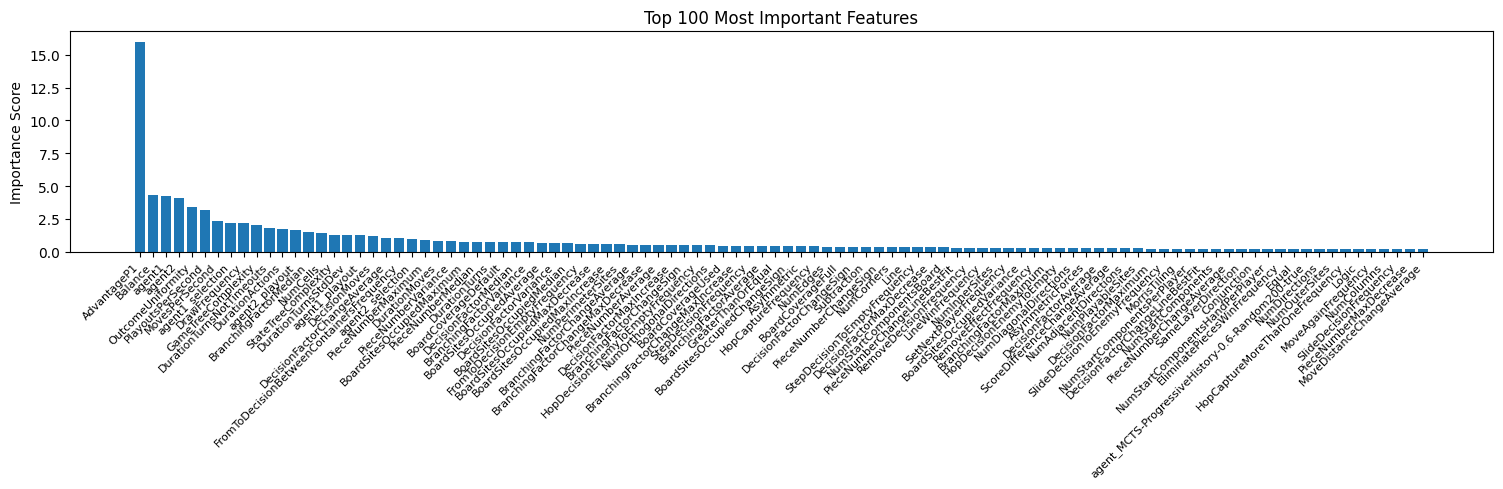

Fold 1 - RMSE: 0.4034975692124585
Fold 2


0:	learn: 0.6147668	test: 0.5376651	best: 0.5376651 (0)	total: 72ms	remaining: 3m 35s


50:	learn: 0.3883218	test: 0.4214710	best: 0.4214710 (50)	total: 3.83s	remaining: 3m 41s


100:	learn: 0.3484740	test: 0.4115806	best: 0.4115806 (100)	total: 7.88s	remaining: 3m 46s


150:	learn: 0.3257350	test: 0.4055015	best: 0.4055015 (150)	total: 11.8s	remaining: 3m 43s


200:	learn: 0.3116674	test: 0.4036117	best: 0.4035513 (197)	total: 15.9s	remaining: 3m 41s


250:	learn: 0.3005092	test: 0.4024556	best: 0.4022553 (244)	total: 19.9s	remaining: 3m 38s


300:	learn: 0.2912637	test: 0.4013620	best: 0.4013620 (300)	total: 23.9s	remaining: 3m 34s


350:	learn: 0.2836449	test: 0.4008162	best: 0.4007057 (344)	total: 28.1s	remaining: 3m 31s


400:	learn: 0.2767578	test: 0.4007107	best: 0.4006268 (381)	total: 32s	remaining: 3m 27s


450:	learn: 0.2701525	test: 0.4001159	best: 0.4001159 (450)	total: 36s	remaining: 3m 23s


500:	learn: 0.2641658	test: 0.3995812	best: 0.3995812 (500)	total: 40.1s	remaining: 3m 19s


550:	learn: 0.2589459	test: 0.3993861	best: 0.3993696 (549)	total: 44.1s	remaining: 3m 16s


600:	learn: 0.2546457	test: 0.3991989	best: 0.3990301 (584)	total: 48.2s	remaining: 3m 12s


650:	learn: 0.2501657	test: 0.3990237	best: 0.3989893 (639)	total: 52.2s	remaining: 3m 8s


700:	learn: 0.2463742	test: 0.3988998	best: 0.3988427 (698)	total: 56.3s	remaining: 3m 4s


750:	learn: 0.2429309	test: 0.3990399	best: 0.3987999 (715)	total: 1m	remaining: 3m


800:	learn: 0.2394221	test: 0.3987408	best: 0.3987408 (800)	total: 1m 4s	remaining: 2m 56s


850:	learn: 0.2360732	test: 0.3988396	best: 0.3987273 (804)	total: 1m 8s	remaining: 2m 52s


900:	learn: 0.2330131	test: 0.3989083	best: 0.3987273 (804)	total: 1m 12s	remaining: 2m 49s


950:	learn: 0.2302086	test: 0.3989067	best: 0.3987273 (804)	total: 1m 16s	remaining: 2m 44s


1000:	learn: 0.2275008	test: 0.3988801	best: 0.3987273 (804)	total: 1m 20s	remaining: 2m 41s


1050:	learn: 0.2251311	test: 0.3989379	best: 0.3987273 (804)	total: 1m 24s	remaining: 2m 36s


1100:	learn: 0.2227523	test: 0.3987911	best: 0.3987273 (804)	total: 1m 28s	remaining: 2m 32s


1150:	learn: 0.2205534	test: 0.3986782	best: 0.3986633 (1143)	total: 1m 32s	remaining: 2m 28s


1200:	learn: 0.2182002	test: 0.3985916	best: 0.3985878 (1199)	total: 1m 36s	remaining: 2m 24s


1250:	learn: 0.2159872	test: 0.3984682	best: 0.3984574 (1248)	total: 1m 40s	remaining: 2m 20s


1300:	learn: 0.2138801	test: 0.3983619	best: 0.3983619 (1300)	total: 1m 44s	remaining: 2m 16s


1350:	learn: 0.2118549	test: 0.3983187	best: 0.3982493 (1331)	total: 1m 48s	remaining: 2m 12s


1400:	learn: 0.2099152	test: 0.3982776	best: 0.3982493 (1331)	total: 1m 52s	remaining: 2m 8s


1450:	learn: 0.2081114	test: 0.3983067	best: 0.3982493 (1331)	total: 1m 57s	remaining: 2m 4s


1500:	learn: 0.2062691	test: 0.3983040	best: 0.3981994 (1479)	total: 2m 1s	remaining: 2m


1550:	learn: 0.2044503	test: 0.3983143	best: 0.3981994 (1479)	total: 2m 5s	remaining: 1m 56s


1600:	learn: 0.2027969	test: 0.3982664	best: 0.3981994 (1479)	total: 2m 9s	remaining: 1m 52s


1650:	learn: 0.2010830	test: 0.3981915	best: 0.3981915 (1650)	total: 2m 13s	remaining: 1m 48s


1700:	learn: 0.1994288	test: 0.3981651	best: 0.3981474 (1672)	total: 2m 17s	remaining: 1m 44s


1750:	learn: 0.1977871	test: 0.3982386	best: 0.3981474 (1672)	total: 2m 21s	remaining: 1m 40s


1800:	learn: 0.1961379	test: 0.3982399	best: 0.3981474 (1672)	total: 2m 25s	remaining: 1m 36s


1850:	learn: 0.1944451	test: 0.3982903	best: 0.3981474 (1672)	total: 2m 29s	remaining: 1m 32s


1900:	learn: 0.1929254	test: 0.3983861	best: 0.3981474 (1672)	total: 2m 33s	remaining: 1m 28s


1950:	learn: 0.1914952	test: 0.3983774	best: 0.3981474 (1672)	total: 2m 37s	remaining: 1m 24s


2000:	learn: 0.1900712	test: 0.3983825	best: 0.3981474 (1672)	total: 2m 41s	remaining: 1m 20s


2050:	learn: 0.1885769	test: 0.3983880	best: 0.3981474 (1672)	total: 2m 45s	remaining: 1m 16s


2100:	learn: 0.1870811	test: 0.3984817	best: 0.3981474 (1672)	total: 2m 49s	remaining: 1m 12s


2150:	learn: 0.1856414	test: 0.3984989	best: 0.3981474 (1672)	total: 2m 53s	remaining: 1m 8s


2200:	learn: 0.1843681	test: 0.3985123	best: 0.3981474 (1672)	total: 2m 58s	remaining: 1m 4s


2250:	learn: 0.1830335	test: 0.3985088	best: 0.3981474 (1672)	total: 3m 2s	remaining: 1m


2300:	learn: 0.1817878	test: 0.3985560	best: 0.3981474 (1672)	total: 3m 6s	remaining: 56.6s


2350:	learn: 0.1805309	test: 0.3985404	best: 0.3981474 (1672)	total: 3m 10s	remaining: 52.5s


2400:	learn: 0.1794107	test: 0.3985877	best: 0.3981474 (1672)	total: 3m 14s	remaining: 48.5s


2450:	learn: 0.1780397	test: 0.3987156	best: 0.3981474 (1672)	total: 3m 18s	remaining: 44.5s


2500:	learn: 0.1768355	test: 0.3987457	best: 0.3981474 (1672)	total: 3m 22s	remaining: 40.4s


2550:	learn: 0.1756552	test: 0.3987337	best: 0.3981474 (1672)	total: 3m 26s	remaining: 36.4s


2600:	learn: 0.1744515	test: 0.3988572	best: 0.3981474 (1672)	total: 3m 30s	remaining: 32.3s


2650:	learn: 0.1733323	test: 0.3988840	best: 0.3981474 (1672)	total: 3m 34s	remaining: 28.3s


2700:	learn: 0.1722183	test: 0.3989392	best: 0.3981474 (1672)	total: 3m 38s	remaining: 24.2s


2750:	learn: 0.1710486	test: 0.3989409	best: 0.3981474 (1672)	total: 3m 42s	remaining: 20.2s


2800:	learn: 0.1698991	test: 0.3989842	best: 0.3981474 (1672)	total: 3m 46s	remaining: 16.1s


2850:	learn: 0.1688086	test: 0.3990050	best: 0.3981474 (1672)	total: 3m 51s	remaining: 12.1s


2900:	learn: 0.1676986	test: 0.3989876	best: 0.3981474 (1672)	total: 3m 55s	remaining: 8.02s


2950:	learn: 0.1665819	test: 0.3989454	best: 0.3981474 (1672)	total: 3m 59s	remaining: 3.97s


2999:	learn: 0.1656294	test: 0.3990293	best: 0.3981474 (1672)	total: 4m 3s	remaining: 0us

bestTest = 0.3981474492
bestIteration = 1672

Shrink model to first 1673 iterations.


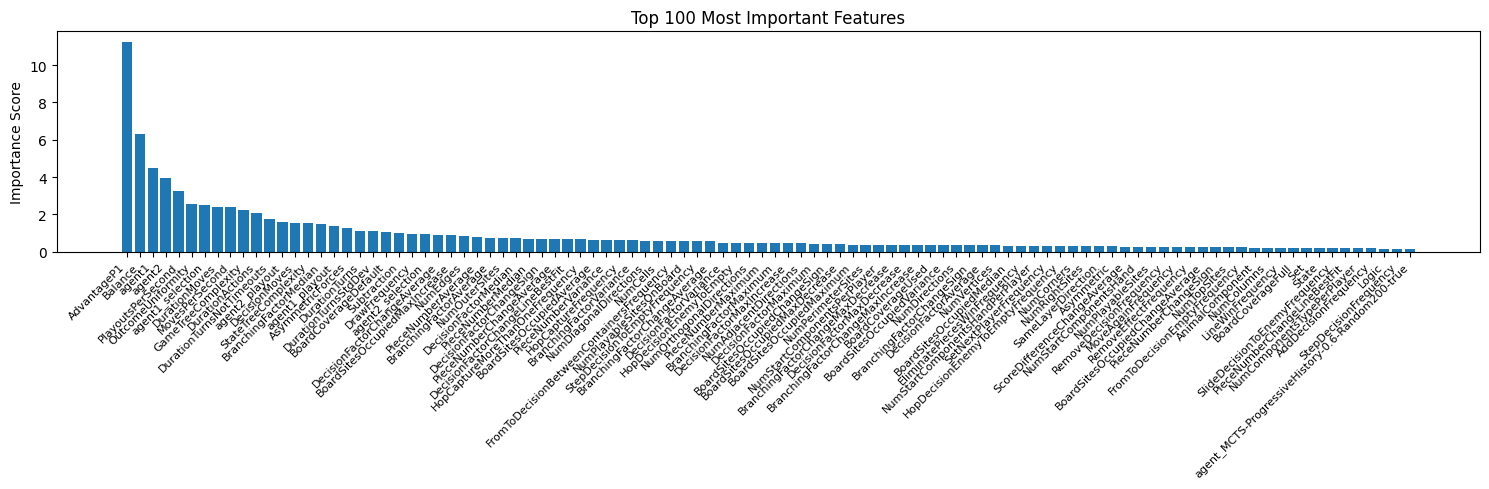

Fold 2 - RMSE: 0.39772904137318904
Fold 3


0:	learn: 0.6008448	test: 0.6074996	best: 0.6074996 (0)	total: 69ms	remaining: 3m 26s


50:	learn: 0.3793172	test: 0.4794797	best: 0.4794797 (50)	total: 3.9s	remaining: 3m 45s


100:	learn: 0.3414629	test: 0.4556968	best: 0.4556968 (100)	total: 7.96s	remaining: 3m 48s


150:	learn: 0.3194582	test: 0.4454847	best: 0.4454847 (150)	total: 11.9s	remaining: 3m 45s


200:	learn: 0.3065363	test: 0.4421118	best: 0.4421118 (200)	total: 16s	remaining: 3m 43s


250:	learn: 0.2955501	test: 0.4389311	best: 0.4389311 (250)	total: 20s	remaining: 3m 39s


300:	learn: 0.2868703	test: 0.4360401	best: 0.4360401 (300)	total: 24s	remaining: 3m 35s


350:	learn: 0.2789959	test: 0.4348727	best: 0.4348220 (346)	total: 28s	remaining: 3m 31s


400:	learn: 0.2722066	test: 0.4337170	best: 0.4337170 (400)	total: 32s	remaining: 3m 27s


450:	learn: 0.2663147	test: 0.4326278	best: 0.4326207 (445)	total: 36s	remaining: 3m 23s


500:	learn: 0.2608197	test: 0.4320610	best: 0.4320610 (500)	total: 40s	remaining: 3m 19s


550:	learn: 0.2562667	test: 0.4312424	best: 0.4312424 (550)	total: 44.1s	remaining: 3m 16s


600:	learn: 0.2523641	test: 0.4306921	best: 0.4306907 (596)	total: 48.1s	remaining: 3m 12s


650:	learn: 0.2484270	test: 0.4303596	best: 0.4303458 (649)	total: 52.1s	remaining: 3m 8s


700:	learn: 0.2447285	test: 0.4297967	best: 0.4297826 (697)	total: 56.2s	remaining: 3m 4s


750:	learn: 0.2413990	test: 0.4293892	best: 0.4293820 (749)	total: 1m	remaining: 3m


800:	learn: 0.2382675	test: 0.4292822	best: 0.4291980 (782)	total: 1m 4s	remaining: 2m 56s


850:	learn: 0.2349934	test: 0.4288680	best: 0.4288330 (842)	total: 1m 8s	remaining: 2m 52s


900:	learn: 0.2323007	test: 0.4286310	best: 0.4286310 (900)	total: 1m 12s	remaining: 2m 48s


950:	learn: 0.2295959	test: 0.4283226	best: 0.4283164 (949)	total: 1m 16s	remaining: 2m 44s


1000:	learn: 0.2270950	test: 0.4282775	best: 0.4282409 (995)	total: 1m 20s	remaining: 2m 40s


1050:	learn: 0.2246295	test: 0.4280230	best: 0.4280153 (1048)	total: 1m 24s	remaining: 2m 36s


1100:	learn: 0.2222359	test: 0.4278971	best: 0.4278940 (1093)	total: 1m 28s	remaining: 2m 33s


1150:	learn: 0.2200373	test: 0.4278030	best: 0.4277861 (1145)	total: 1m 32s	remaining: 2m 28s


1200:	learn: 0.2176883	test: 0.4276551	best: 0.4276446 (1196)	total: 1m 36s	remaining: 2m 25s


1250:	learn: 0.2155958	test: 0.4274164	best: 0.4274164 (1250)	total: 1m 40s	remaining: 2m 21s


1300:	learn: 0.2135764	test: 0.4272004	best: 0.4272004 (1300)	total: 1m 44s	remaining: 2m 17s


1350:	learn: 0.2115569	test: 0.4271139	best: 0.4270944 (1340)	total: 1m 49s	remaining: 2m 13s


1400:	learn: 0.2095892	test: 0.4270631	best: 0.4270412 (1379)	total: 1m 53s	remaining: 2m 8s


1450:	learn: 0.2077543	test: 0.4269803	best: 0.4269803 (1450)	total: 1m 57s	remaining: 2m 4s


1500:	learn: 0.2058319	test: 0.4269061	best: 0.4269000 (1497)	total: 2m 1s	remaining: 2m


1550:	learn: 0.2040815	test: 0.4267459	best: 0.4267459 (1550)	total: 2m 5s	remaining: 1m 56s


1600:	learn: 0.2023487	test: 0.4266849	best: 0.4266662 (1597)	total: 2m 9s	remaining: 1m 52s


1650:	learn: 0.2008171	test: 0.4265912	best: 0.4265807 (1645)	total: 2m 13s	remaining: 1m 48s


1700:	learn: 0.1992742	test: 0.4265045	best: 0.4264913 (1696)	total: 2m 17s	remaining: 1m 44s


1750:	learn: 0.1976432	test: 0.4262729	best: 0.4262627 (1747)	total: 2m 21s	remaining: 1m 40s


1800:	learn: 0.1960016	test: 0.4262390	best: 0.4262240 (1782)	total: 2m 25s	remaining: 1m 36s


1850:	learn: 0.1944899	test: 0.4261843	best: 0.4261843 (1850)	total: 2m 29s	remaining: 1m 32s


1900:	learn: 0.1929120	test: 0.4260511	best: 0.4260511 (1900)	total: 2m 33s	remaining: 1m 28s


1950:	learn: 0.1913624	test: 0.4259923	best: 0.4259913 (1944)	total: 2m 37s	remaining: 1m 24s


2000:	learn: 0.1897999	test: 0.4259025	best: 0.4258761 (1979)	total: 2m 41s	remaining: 1m 20s


2050:	learn: 0.1884737	test: 0.4258319	best: 0.4258100 (2042)	total: 2m 45s	remaining: 1m 16s


2100:	learn: 0.1869787	test: 0.4257424	best: 0.4257294 (2097)	total: 2m 50s	remaining: 1m 12s


2150:	learn: 0.1855006	test: 0.4256086	best: 0.4256025 (2144)	total: 2m 54s	remaining: 1m 8s


2200:	learn: 0.1842219	test: 0.4256400	best: 0.4255987 (2152)	total: 2m 58s	remaining: 1m 4s


2250:	learn: 0.1828997	test: 0.4255464	best: 0.4255464 (2250)	total: 3m 2s	remaining: 1m


2300:	learn: 0.1816229	test: 0.4255369	best: 0.4254940 (2273)	total: 3m 6s	remaining: 56.6s


2350:	learn: 0.1804101	test: 0.4255920	best: 0.4254940 (2273)	total: 3m 10s	remaining: 52.6s


2400:	learn: 0.1791720	test: 0.4255849	best: 0.4254940 (2273)	total: 3m 14s	remaining: 48.5s


2450:	learn: 0.1778734	test: 0.4255475	best: 0.4254940 (2273)	total: 3m 18s	remaining: 44.5s


2500:	learn: 0.1766406	test: 0.4255181	best: 0.4254940 (2273)	total: 3m 22s	remaining: 40.5s


2550:	learn: 0.1753623	test: 0.4255285	best: 0.4254940 (2273)	total: 3m 26s	remaining: 36.4s


2600:	learn: 0.1742273	test: 0.4255038	best: 0.4254803 (2579)	total: 3m 30s	remaining: 32.3s


2650:	learn: 0.1731884	test: 0.4254588	best: 0.4254357 (2622)	total: 3m 34s	remaining: 28.3s


2700:	learn: 0.1720117	test: 0.4254759	best: 0.4254357 (2622)	total: 3m 39s	remaining: 24.2s


2750:	learn: 0.1708651	test: 0.4254131	best: 0.4253889 (2733)	total: 3m 43s	remaining: 20.2s


2800:	learn: 0.1696885	test: 0.4254019	best: 0.4253845 (2780)	total: 3m 47s	remaining: 16.1s


2850:	learn: 0.1685712	test: 0.4253980	best: 0.4253704 (2835)	total: 3m 51s	remaining: 12.1s


2900:	learn: 0.1675778	test: 0.4253609	best: 0.4253439 (2884)	total: 3m 55s	remaining: 8.03s


2950:	learn: 0.1665044	test: 0.4253535	best: 0.4253439 (2884)	total: 3m 59s	remaining: 3.98s


2999:	learn: 0.1655438	test: 0.4253575	best: 0.4253241 (2982)	total: 4m 3s	remaining: 0us

bestTest = 0.4253241404
bestIteration = 2982

Shrink model to first 2983 iterations.


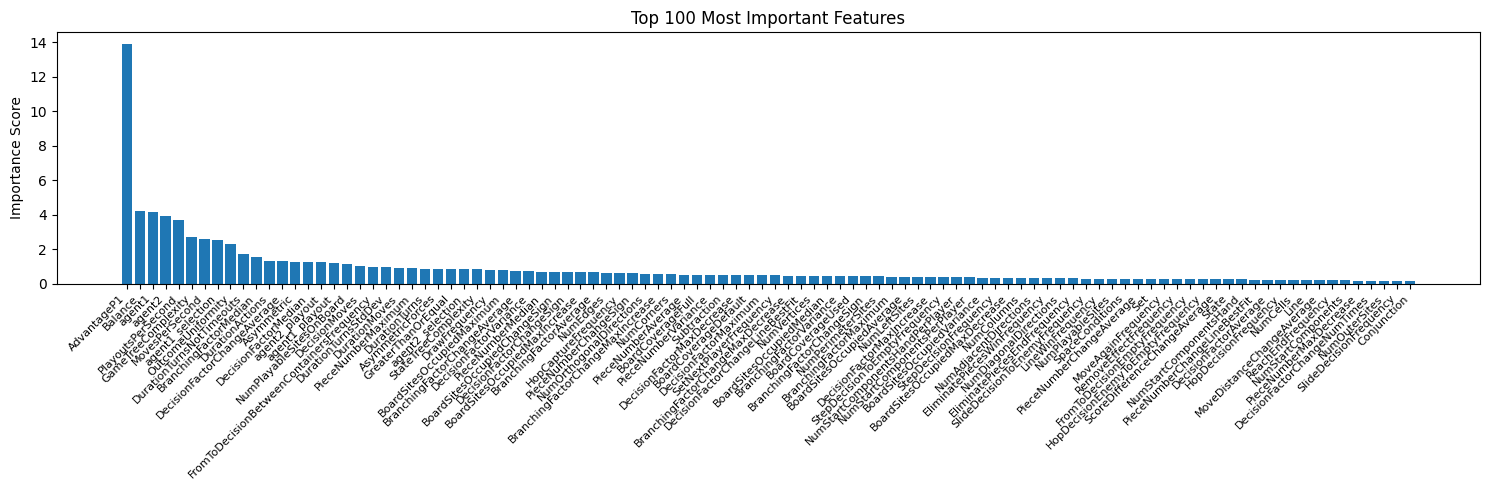

Fold 3 - RMSE: 0.4244033803935503
Fold 4


0:	learn: 0.6032466	test: 0.5977961	best: 0.5977961 (0)	total: 72.3ms	remaining: 3m 36s


50:	learn: 0.3873712	test: 0.4854377	best: 0.4854377 (50)	total: 3.9s	remaining: 3m 45s


100:	learn: 0.3499928	test: 0.4672498	best: 0.4672498 (100)	total: 7.98s	remaining: 3m 49s


150:	learn: 0.3276163	test: 0.4586190	best: 0.4585795 (148)	total: 11.9s	remaining: 3m 45s


200:	learn: 0.3144547	test: 0.4559050	best: 0.4559050 (200)	total: 16s	remaining: 3m 43s


250:	learn: 0.3032673	test: 0.4537520	best: 0.4536550 (246)	total: 20.1s	remaining: 3m 40s


300:	learn: 0.2945407	test: 0.4518923	best: 0.4518619 (294)	total: 24.2s	remaining: 3m 36s


350:	learn: 0.2862762	test: 0.4508767	best: 0.4508767 (350)	total: 28.3s	remaining: 3m 33s


400:	learn: 0.2795831	test: 0.4494150	best: 0.4494150 (400)	total: 32.4s	remaining: 3m 29s


450:	learn: 0.2734882	test: 0.4483509	best: 0.4483191 (445)	total: 36.5s	remaining: 3m 26s


500:	learn: 0.2682374	test: 0.4474613	best: 0.4474465 (499)	total: 40.5s	remaining: 3m 22s


550:	learn: 0.2635928	test: 0.4469987	best: 0.4469253 (534)	total: 44.7s	remaining: 3m 18s


600:	learn: 0.2590758	test: 0.4468500	best: 0.4468271 (598)	total: 48.8s	remaining: 3m 14s


650:	learn: 0.2551715	test: 0.4466876	best: 0.4466399 (628)	total: 53s	remaining: 3m 11s


700:	learn: 0.2510229	test: 0.4466597	best: 0.4466399 (628)	total: 57.1s	remaining: 3m 7s


750:	learn: 0.2472629	test: 0.4463179	best: 0.4463179 (750)	total: 1m 1s	remaining: 3m 3s


800:	learn: 0.2439405	test: 0.4459815	best: 0.4459280 (790)	total: 1m 5s	remaining: 2m 58s


850:	learn: 0.2406434	test: 0.4456462	best: 0.4456445 (849)	total: 1m 9s	remaining: 2m 55s


900:	learn: 0.2376322	test: 0.4451760	best: 0.4451638 (899)	total: 1m 13s	remaining: 2m 50s


950:	learn: 0.2347114	test: 0.4450193	best: 0.4450193 (950)	total: 1m 17s	remaining: 2m 46s


1000:	learn: 0.2321074	test: 0.4448451	best: 0.4448019 (997)	total: 1m 21s	remaining: 2m 42s


1050:	learn: 0.2296102	test: 0.4445975	best: 0.4445975 (1050)	total: 1m 25s	remaining: 2m 39s


1100:	learn: 0.2271363	test: 0.4444110	best: 0.4443793 (1090)	total: 1m 29s	remaining: 2m 35s


1150:	learn: 0.2247171	test: 0.4442342	best: 0.4442342 (1150)	total: 1m 34s	remaining: 2m 31s


1200:	learn: 0.2222327	test: 0.4442095	best: 0.4441680 (1187)	total: 1m 38s	remaining: 2m 27s


1250:	learn: 0.2202187	test: 0.4441102	best: 0.4441058 (1249)	total: 1m 42s	remaining: 2m 23s


1300:	learn: 0.2181681	test: 0.4439213	best: 0.4439213 (1300)	total: 1m 46s	remaining: 2m 19s


1350:	learn: 0.2161596	test: 0.4437621	best: 0.4437563 (1349)	total: 1m 50s	remaining: 2m 15s


1400:	learn: 0.2142691	test: 0.4436080	best: 0.4435926 (1367)	total: 1m 54s	remaining: 2m 11s


1450:	learn: 0.2124224	test: 0.4435319	best: 0.4435127 (1434)	total: 1m 59s	remaining: 2m 7s


1500:	learn: 0.2106063	test: 0.4434459	best: 0.4433820 (1479)	total: 2m 3s	remaining: 2m 3s


1550:	learn: 0.2088628	test: 0.4433416	best: 0.4433416 (1550)	total: 2m 7s	remaining: 1m 59s


1600:	learn: 0.2071758	test: 0.4432981	best: 0.4432742 (1590)	total: 2m 11s	remaining: 1m 54s


1650:	learn: 0.2055477	test: 0.4433419	best: 0.4432742 (1590)	total: 2m 15s	remaining: 1m 50s


1700:	learn: 0.2038942	test: 0.4433397	best: 0.4432742 (1590)	total: 2m 19s	remaining: 1m 46s


1750:	learn: 0.2022596	test: 0.4432852	best: 0.4432646 (1746)	total: 2m 23s	remaining: 1m 42s


1800:	learn: 0.2007156	test: 0.4432890	best: 0.4432524 (1770)	total: 2m 28s	remaining: 1m 38s


1850:	learn: 0.1990844	test: 0.4431013	best: 0.4431013 (1850)	total: 2m 32s	remaining: 1m 34s


1900:	learn: 0.1975132	test: 0.4430487	best: 0.4430288 (1867)	total: 2m 36s	remaining: 1m 30s


1950:	learn: 0.1959211	test: 0.4429677	best: 0.4429464 (1938)	total: 2m 40s	remaining: 1m 26s


2000:	learn: 0.1944341	test: 0.4429110	best: 0.4429110 (2000)	total: 2m 44s	remaining: 1m 22s


2050:	learn: 0.1929595	test: 0.4428756	best: 0.4428469 (2016)	total: 2m 48s	remaining: 1m 18s


2100:	learn: 0.1915908	test: 0.4429185	best: 0.4428469 (2016)	total: 2m 52s	remaining: 1m 14s


2150:	learn: 0.1902705	test: 0.4429708	best: 0.4428469 (2016)	total: 2m 57s	remaining: 1m 9s


2200:	learn: 0.1889414	test: 0.4429458	best: 0.4428469 (2016)	total: 3m 1s	remaining: 1m 5s


2250:	learn: 0.1875989	test: 0.4429502	best: 0.4428469 (2016)	total: 3m 5s	remaining: 1m 1s


2300:	learn: 0.1863495	test: 0.4429099	best: 0.4428469 (2016)	total: 3m 9s	remaining: 57.6s


2350:	learn: 0.1851273	test: 0.4428361	best: 0.4428309 (2349)	total: 3m 13s	remaining: 53.5s


2400:	learn: 0.1838595	test: 0.4428303	best: 0.4428228 (2356)	total: 3m 17s	remaining: 49.4s


2450:	learn: 0.1826771	test: 0.4427323	best: 0.4427323 (2450)	total: 3m 21s	remaining: 45.2s


2500:	learn: 0.1813337	test: 0.4426933	best: 0.4426742 (2493)	total: 3m 26s	remaining: 41.1s


2550:	learn: 0.1801518	test: 0.4427073	best: 0.4426742 (2493)	total: 3m 30s	remaining: 37s


2600:	learn: 0.1789010	test: 0.4427836	best: 0.4426742 (2493)	total: 3m 34s	remaining: 32.9s


2650:	learn: 0.1777173	test: 0.4428544	best: 0.4426742 (2493)	total: 3m 38s	remaining: 28.8s


2700:	learn: 0.1764167	test: 0.4428158	best: 0.4426742 (2493)	total: 3m 42s	remaining: 24.6s


2750:	learn: 0.1753300	test: 0.4427749	best: 0.4426742 (2493)	total: 3m 46s	remaining: 20.5s


2800:	learn: 0.1742054	test: 0.4427807	best: 0.4426742 (2493)	total: 3m 50s	remaining: 16.4s


2850:	learn: 0.1730188	test: 0.4428011	best: 0.4426742 (2493)	total: 3m 55s	remaining: 12.3s


2900:	learn: 0.1720244	test: 0.4427345	best: 0.4426742 (2493)	total: 3m 59s	remaining: 8.16s


2950:	learn: 0.1709619	test: 0.4426965	best: 0.4426742 (2493)	total: 4m 3s	remaining: 4.04s


2999:	learn: 0.1698239	test: 0.4426742	best: 0.4426720 (2967)	total: 4m 7s	remaining: 0us

bestTest = 0.4426719623
bestIteration = 2967

Shrink model to first 2968 iterations.


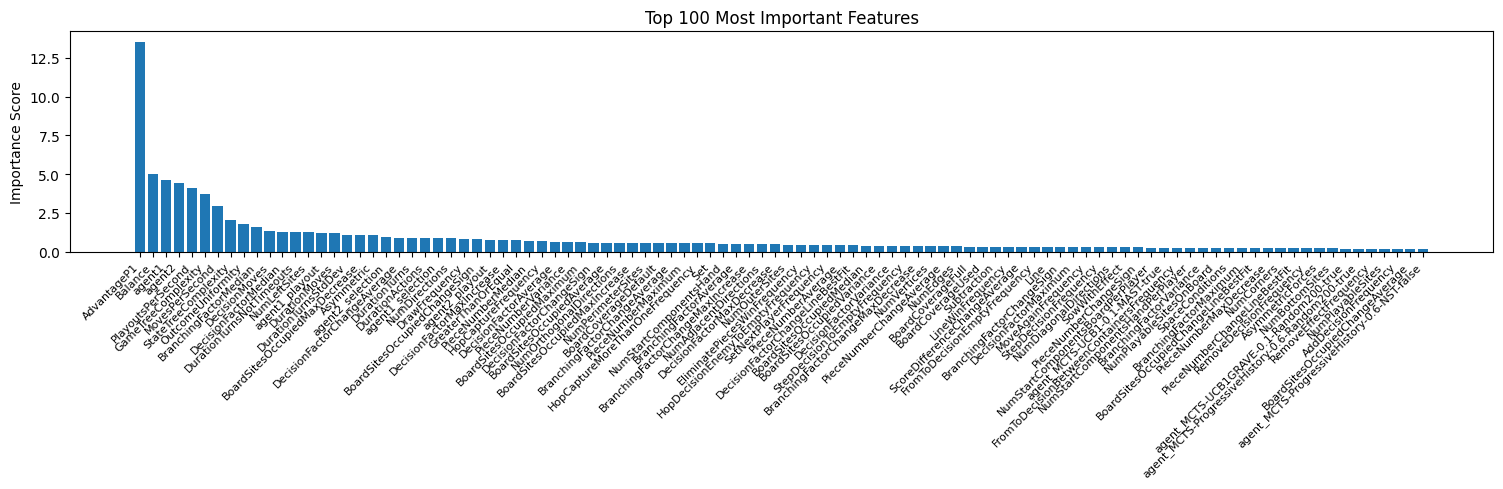

Fold 4 - RMSE: 0.4421927330668206
Fold 5


0:	learn: 0.6049918	test: 0.5861426	best: 0.5861426 (0)	total: 60.6ms	remaining: 3m 1s


50:	learn: 0.3838339	test: 0.4838508	best: 0.4838508 (50)	total: 3.79s	remaining: 3m 39s


100:	learn: 0.3459047	test: 0.4645673	best: 0.4645673 (100)	total: 7.75s	remaining: 3m 42s


150:	learn: 0.3255702	test: 0.4558177	best: 0.4558097 (149)	total: 11.7s	remaining: 3m 41s


200:	learn: 0.3114472	test: 0.4514623	best: 0.4514623 (200)	total: 15.7s	remaining: 3m 38s


250:	learn: 0.3000713	test: 0.4487779	best: 0.4485805 (248)	total: 19.8s	remaining: 3m 36s


300:	learn: 0.2905687	test: 0.4465150	best: 0.4465150 (300)	total: 23.8s	remaining: 3m 33s


350:	learn: 0.2829490	test: 0.4448180	best: 0.4447172 (346)	total: 27.9s	remaining: 3m 30s


400:	learn: 0.2762857	test: 0.4435169	best: 0.4435169 (400)	total: 31.9s	remaining: 3m 26s


450:	learn: 0.2700821	test: 0.4429101	best: 0.4428756 (448)	total: 35.9s	remaining: 3m 23s


500:	learn: 0.2651320	test: 0.4425257	best: 0.4425257 (500)	total: 40s	remaining: 3m 19s


550:	learn: 0.2603801	test: 0.4416307	best: 0.4416307 (550)	total: 44s	remaining: 3m 15s


600:	learn: 0.2558357	test: 0.4408656	best: 0.4408656 (600)	total: 48.1s	remaining: 3m 11s


650:	learn: 0.2514904	test: 0.4402768	best: 0.4402768 (650)	total: 52.1s	remaining: 3m 7s


700:	learn: 0.2476951	test: 0.4397378	best: 0.4397280 (698)	total: 56.1s	remaining: 3m 3s


750:	learn: 0.2443861	test: 0.4391630	best: 0.4391630 (750)	total: 1m	remaining: 3m


800:	learn: 0.2409599	test: 0.4391306	best: 0.4389974 (788)	total: 1m 4s	remaining: 2m 56s


850:	learn: 0.2381092	test: 0.4388771	best: 0.4388707 (849)	total: 1m 8s	remaining: 2m 52s


900:	learn: 0.2352631	test: 0.4386532	best: 0.4386484 (899)	total: 1m 12s	remaining: 2m 48s


950:	learn: 0.2323754	test: 0.4382742	best: 0.4382742 (950)	total: 1m 16s	remaining: 2m 44s


1000:	learn: 0.2296821	test: 0.4383577	best: 0.4382522 (952)	total: 1m 20s	remaining: 2m 40s


1050:	learn: 0.2272367	test: 0.4381768	best: 0.4381768 (1050)	total: 1m 24s	remaining: 2m 36s


1100:	learn: 0.2249638	test: 0.4380440	best: 0.4380440 (1100)	total: 1m 28s	remaining: 2m 32s


1150:	learn: 0.2225738	test: 0.4377747	best: 0.4377580 (1148)	total: 1m 32s	remaining: 2m 28s


1200:	learn: 0.2204775	test: 0.4375368	best: 0.4375278 (1199)	total: 1m 36s	remaining: 2m 25s


1250:	learn: 0.2182564	test: 0.4374403	best: 0.4374341 (1249)	total: 1m 40s	remaining: 2m 21s


1300:	learn: 0.2162328	test: 0.4372512	best: 0.4372469 (1299)	total: 1m 44s	remaining: 2m 17s


1350:	learn: 0.2141675	test: 0.4370181	best: 0.4370133 (1349)	total: 1m 49s	remaining: 2m 13s


1400:	learn: 0.2122500	test: 0.4370878	best: 0.4369963 (1356)	total: 1m 53s	remaining: 2m 9s


1450:	learn: 0.2104024	test: 0.4370850	best: 0.4369963 (1356)	total: 1m 57s	remaining: 2m 5s


1500:	learn: 0.2084379	test: 0.4370260	best: 0.4369963 (1356)	total: 2m 1s	remaining: 2m 1s


1550:	learn: 0.2068636	test: 0.4368350	best: 0.4368350 (1550)	total: 2m 5s	remaining: 1m 57s


1600:	learn: 0.2050926	test: 0.4368136	best: 0.4367814 (1589)	total: 2m 9s	remaining: 1m 53s


1650:	learn: 0.2033373	test: 0.4368226	best: 0.4367814 (1589)	total: 2m 13s	remaining: 1m 49s


1700:	learn: 0.2017659	test: 0.4368224	best: 0.4367814 (1589)	total: 2m 17s	remaining: 1m 45s


1750:	learn: 0.2001858	test: 0.4366526	best: 0.4366526 (1750)	total: 2m 21s	remaining: 1m 41s


1800:	learn: 0.1984647	test: 0.4366777	best: 0.4365994 (1776)	total: 2m 25s	remaining: 1m 37s


1850:	learn: 0.1969399	test: 0.4366495	best: 0.4365994 (1776)	total: 2m 29s	remaining: 1m 33s


1900:	learn: 0.1954365	test: 0.4366400	best: 0.4365994 (1776)	total: 2m 33s	remaining: 1m 28s


1950:	learn: 0.1940113	test: 0.4366089	best: 0.4365845 (1943)	total: 2m 37s	remaining: 1m 24s


2000:	learn: 0.1926417	test: 0.4366106	best: 0.4365845 (1943)	total: 2m 42s	remaining: 1m 20s


2050:	learn: 0.1912542	test: 0.4365815	best: 0.4365815 (2050)	total: 2m 46s	remaining: 1m 16s


2100:	learn: 0.1898781	test: 0.4365453	best: 0.4365198 (2070)	total: 2m 50s	remaining: 1m 12s


2150:	learn: 0.1883091	test: 0.4365848	best: 0.4365180 (2122)	total: 2m 54s	remaining: 1m 8s


2200:	learn: 0.1870193	test: 0.4366339	best: 0.4365180 (2122)	total: 2m 58s	remaining: 1m 4s


2250:	learn: 0.1856691	test: 0.4365994	best: 0.4365180 (2122)	total: 3m 2s	remaining: 1m


2300:	learn: 0.1843700	test: 0.4365938	best: 0.4365180 (2122)	total: 3m 6s	remaining: 56.7s


2350:	learn: 0.1831533	test: 0.4365699	best: 0.4365180 (2122)	total: 3m 10s	remaining: 52.7s


2400:	learn: 0.1820162	test: 0.4366127	best: 0.4365180 (2122)	total: 3m 15s	remaining: 48.6s


2450:	learn: 0.1808465	test: 0.4366212	best: 0.4365180 (2122)	total: 3m 19s	remaining: 44.6s


2500:	learn: 0.1795860	test: 0.4365172	best: 0.4365172 (2500)	total: 3m 23s	remaining: 40.5s


2550:	learn: 0.1783879	test: 0.4365624	best: 0.4364984 (2502)	total: 3m 27s	remaining: 36.5s


2600:	learn: 0.1771117	test: 0.4365024	best: 0.4364984 (2502)	total: 3m 31s	remaining: 32.4s


2650:	learn: 0.1758951	test: 0.4365103	best: 0.4364984 (2602)	total: 3m 35s	remaining: 28.4s


2700:	learn: 0.1747802	test: 0.4365546	best: 0.4364984 (2602)	total: 3m 39s	remaining: 24.3s


2750:	learn: 0.1736052	test: 0.4365321	best: 0.4364984 (2602)	total: 3m 43s	remaining: 20.3s


2800:	learn: 0.1724626	test: 0.4365900	best: 0.4364984 (2602)	total: 3m 47s	remaining: 16.2s


2850:	learn: 0.1714302	test: 0.4365373	best: 0.4364984 (2602)	total: 3m 51s	remaining: 12.1s


2900:	learn: 0.1704039	test: 0.4365727	best: 0.4364984 (2602)	total: 3m 55s	remaining: 8.05s


2950:	learn: 0.1693746	test: 0.4365546	best: 0.4364984 (2602)	total: 3m 59s	remaining: 3.98s


2999:	learn: 0.1682791	test: 0.4366040	best: 0.4364984 (2602)	total: 4m 4s	remaining: 0us

bestTest = 0.4364983829
bestIteration = 2602

Shrink model to first 2603 iterations.


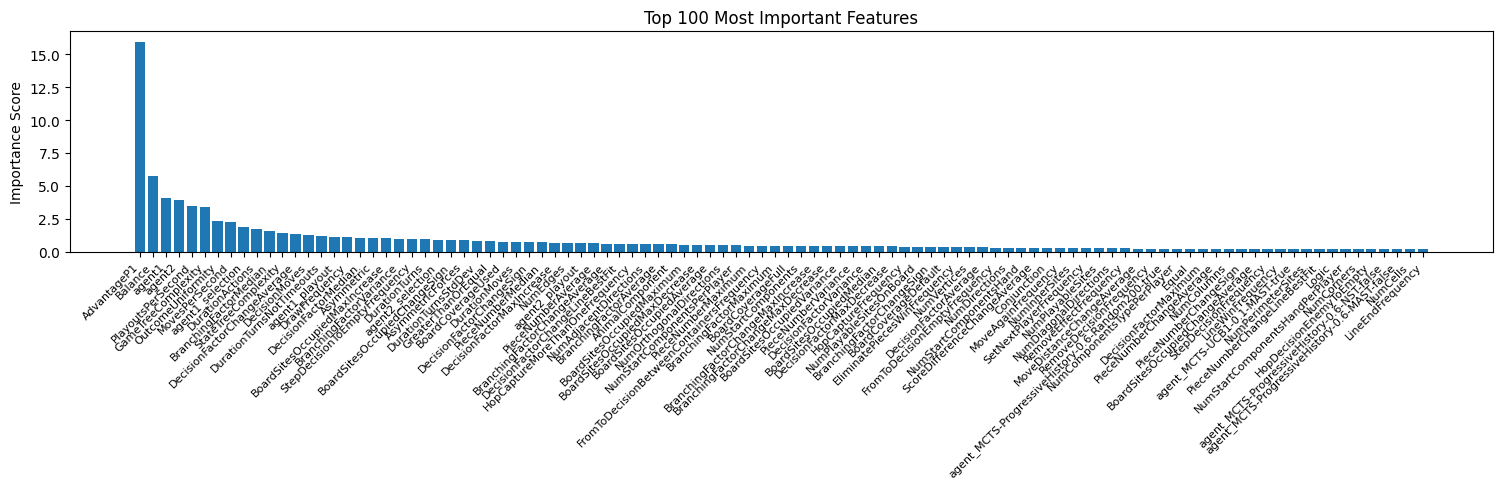

Fold 5 - RMSE: 0.43568234547762164
List of oof scores: [0.4034975692124585, 0.39772904137318904, 0.4244033803935503, 0.4421927330668206, 0.43568234547762164]
Average oof score: 0.42070101390472797


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6094693	test: 0.5701581	best: 0.5701581 (0)	total: 69ms	remaining: 3m 26s


50:	learn: 0.3846920	test: 0.4698893	best: 0.4698893 (50)	total: 3.78s	remaining: 3m 38s


100:	learn: 0.3477458	test: 0.4542057	best: 0.4542057 (100)	total: 7.79s	remaining: 3m 43s


150:	learn: 0.3263129	test: 0.4465240	best: 0.4464136 (149)	total: 11.7s	remaining: 3m 40s


200:	learn: 0.3109172	test: 0.4423587	best: 0.4423587 (200)	total: 15.7s	remaining: 3m 38s


250:	learn: 0.3003751	test: 0.4402427	best: 0.4402398 (247)	total: 19.7s	remaining: 3m 35s


300:	learn: 0.2917682	test: 0.4386840	best: 0.4386134 (296)	total: 23.7s	remaining: 3m 32s


350:	learn: 0.2837459	test: 0.4375309	best: 0.4375229 (349)	total: 27.7s	remaining: 3m 29s


400:	learn: 0.2770982	test: 0.4368122	best: 0.4368122 (400)	total: 31.7s	remaining: 3m 25s


450:	learn: 0.2714758	test: 0.4357606	best: 0.4357606 (450)	total: 35.9s	remaining: 3m 22s


500:	learn: 0.2659389	test: 0.4351079	best: 0.4351079 (500)	total: 39.9s	remaining: 3m 18s


550:	learn: 0.2610329	test: 0.4347921	best: 0.4347921 (550)	total: 43.9s	remaining: 3m 14s


600:	learn: 0.2563965	test: 0.4343106	best: 0.4342878 (596)	total: 47.9s	remaining: 3m 11s


650:	learn: 0.2519001	test: 0.4339543	best: 0.4339543 (650)	total: 51.8s	remaining: 3m 7s


700:	learn: 0.2477314	test: 0.4336657	best: 0.4336657 (700)	total: 55.9s	remaining: 3m 3s


750:	learn: 0.2443881	test: 0.4335076	best: 0.4334708 (742)	total: 60s	remaining: 2m 59s


800:	learn: 0.2409378	test: 0.4333713	best: 0.4333161 (783)	total: 1m 4s	remaining: 2m 55s


850:	learn: 0.2379582	test: 0.4329729	best: 0.4329717 (847)	total: 1m 8s	remaining: 2m 51s


900:	learn: 0.2349478	test: 0.4329917	best: 0.4329717 (847)	total: 1m 12s	remaining: 2m 48s


950:	learn: 0.2320471	test: 0.4329661	best: 0.4329195 (929)	total: 1m 16s	remaining: 2m 44s


1000:	learn: 0.2292914	test: 0.4329203	best: 0.4328708 (996)	total: 1m 20s	remaining: 2m 39s


1050:	learn: 0.2267913	test: 0.4327733	best: 0.4327426 (1047)	total: 1m 24s	remaining: 2m 36s


1100:	learn: 0.2242734	test: 0.4326363	best: 0.4325820 (1095)	total: 1m 28s	remaining: 2m 32s


1150:	learn: 0.2219088	test: 0.4326436	best: 0.4325820 (1095)	total: 1m 32s	remaining: 2m 28s


1200:	learn: 0.2196467	test: 0.4325820	best: 0.4325729 (1194)	total: 1m 36s	remaining: 2m 24s


1250:	learn: 0.2176398	test: 0.4324967	best: 0.4324748 (1245)	total: 1m 40s	remaining: 2m 20s


1300:	learn: 0.2155467	test: 0.4324325	best: 0.4324144 (1296)	total: 1m 44s	remaining: 2m 16s


1350:	learn: 0.2137246	test: 0.4324698	best: 0.4324111 (1330)	total: 1m 48s	remaining: 2m 12s


1400:	learn: 0.2117473	test: 0.4323904	best: 0.4323871 (1397)	total: 1m 52s	remaining: 2m 8s


1450:	learn: 0.2098854	test: 0.4323723	best: 0.4322788 (1428)	total: 1m 56s	remaining: 2m 4s


1500:	learn: 0.2079469	test: 0.4322566	best: 0.4322566 (1500)	total: 2m	remaining: 2m


1550:	learn: 0.2060753	test: 0.4322363	best: 0.4321971 (1509)	total: 2m 4s	remaining: 1m 56s


1600:	learn: 0.2045148	test: 0.4322181	best: 0.4321775 (1569)	total: 2m 8s	remaining: 1m 52s


1650:	learn: 0.2029981	test: 0.4321045	best: 0.4321045 (1650)	total: 2m 12s	remaining: 1m 48s


1700:	learn: 0.2013938	test: 0.4320944	best: 0.4320823 (1697)	total: 2m 16s	remaining: 1m 44s


1750:	learn: 0.1998898	test: 0.4320491	best: 0.4320430 (1733)	total: 2m 21s	remaining: 1m 40s


1800:	learn: 0.1982398	test: 0.4320608	best: 0.4320269 (1751)	total: 2m 25s	remaining: 1m 36s


1850:	learn: 0.1967768	test: 0.4320374	best: 0.4320185 (1842)	total: 2m 29s	remaining: 1m 32s


1900:	learn: 0.1952438	test: 0.4320442	best: 0.4320151 (1892)	total: 2m 33s	remaining: 1m 28s


1950:	learn: 0.1938250	test: 0.4320239	best: 0.4320067 (1938)	total: 2m 37s	remaining: 1m 24s


2000:	learn: 0.1925052	test: 0.4320144	best: 0.4320067 (1938)	total: 2m 41s	remaining: 1m 20s


2050:	learn: 0.1910892	test: 0.4319820	best: 0.4319735 (2046)	total: 2m 45s	remaining: 1m 16s


2100:	learn: 0.1897397	test: 0.4320651	best: 0.4319735 (2046)	total: 2m 49s	remaining: 1m 12s


2150:	learn: 0.1882804	test: 0.4320164	best: 0.4319735 (2046)	total: 2m 53s	remaining: 1m 8s


2200:	learn: 0.1869030	test: 0.4320450	best: 0.4319735 (2046)	total: 2m 57s	remaining: 1m 4s


2250:	learn: 0.1856169	test: 0.4319967	best: 0.4319735 (2046)	total: 3m 1s	remaining: 1m


2300:	learn: 0.1842618	test: 0.4319525	best: 0.4318989 (2278)	total: 3m 5s	remaining: 56.5s


2350:	learn: 0.1829109	test: 0.4319871	best: 0.4318989 (2278)	total: 3m 9s	remaining: 52.4s


2400:	learn: 0.1817900	test: 0.4319418	best: 0.4318989 (2278)	total: 3m 14s	remaining: 48.4s


2450:	learn: 0.1804887	test: 0.4319535	best: 0.4318989 (2278)	total: 3m 18s	remaining: 44.4s


2500:	learn: 0.1792551	test: 0.4319353	best: 0.4318989 (2278)	total: 3m 22s	remaining: 40.3s


2550:	learn: 0.1781191	test: 0.4319496	best: 0.4318973 (2516)	total: 3m 26s	remaining: 36.3s


2600:	learn: 0.1769208	test: 0.4319024	best: 0.4318973 (2516)	total: 3m 30s	remaining: 32.3s


2650:	learn: 0.1757003	test: 0.4318947	best: 0.4318913 (2646)	total: 3m 34s	remaining: 28.2s


2700:	learn: 0.1745804	test: 0.4318067	best: 0.4318063 (2698)	total: 3m 38s	remaining: 24.2s


2750:	learn: 0.1735158	test: 0.4317540	best: 0.4317504 (2749)	total: 3m 42s	remaining: 20.2s


2800:	learn: 0.1723668	test: 0.4317891	best: 0.4317504 (2749)	total: 3m 46s	remaining: 16.1s


2850:	learn: 0.1712453	test: 0.4318476	best: 0.4317504 (2749)	total: 3m 50s	remaining: 12.1s


2900:	learn: 0.1702008	test: 0.4319150	best: 0.4317504 (2749)	total: 3m 55s	remaining: 8.02s


2950:	learn: 0.1691106	test: 0.4319224	best: 0.4317504 (2749)	total: 3m 59s	remaining: 3.97s


2999:	learn: 0.1682304	test: 0.4319226	best: 0.4317504 (2749)	total: 4m 3s	remaining: 0us

bestTest = 0.431750355
bestIteration = 2749

Shrink model to first 2750 iterations.


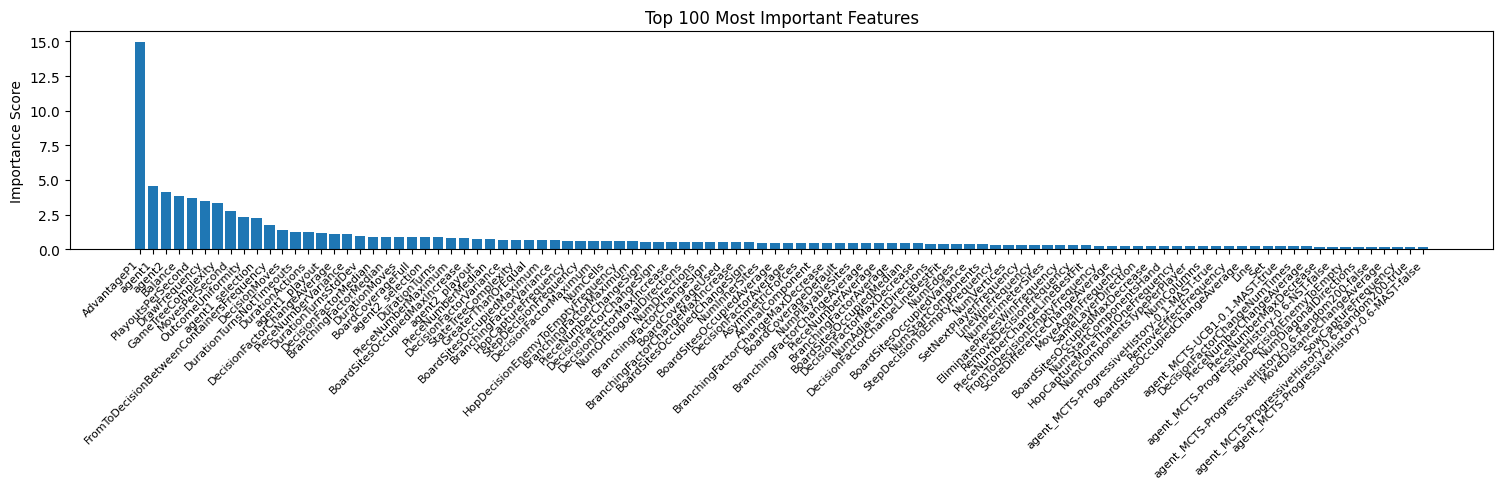

Fold 1 - RMSE: 0.4313805944744417
Fold 2


0:	learn: 0.6072656	test: 0.5709324	best: 0.5709324 (0)	total: 70.4ms	remaining: 3m 31s


50:	learn: 0.3893276	test: 0.4610133	best: 0.4610133 (50)	total: 3.82s	remaining: 3m 40s


100:	learn: 0.3504269	test: 0.4378322	best: 0.4378322 (100)	total: 7.82s	remaining: 3m 44s


150:	learn: 0.3268803	test: 0.4270654	best: 0.4270442 (149)	total: 11.7s	remaining: 3m 41s


200:	learn: 0.3123437	test: 0.4220916	best: 0.4220598 (198)	total: 15.7s	remaining: 3m 38s


250:	learn: 0.3005309	test: 0.4191760	best: 0.4191727 (249)	total: 19.7s	remaining: 3m 35s


300:	learn: 0.2917624	test: 0.4172079	best: 0.4172017 (299)	total: 23.7s	remaining: 3m 32s


350:	learn: 0.2841820	test: 0.4156259	best: 0.4156259 (350)	total: 27.8s	remaining: 3m 29s


400:	learn: 0.2775335	test: 0.4143853	best: 0.4143853 (400)	total: 31.8s	remaining: 3m 26s


450:	learn: 0.2715602	test: 0.4129439	best: 0.4129397 (449)	total: 35.9s	remaining: 3m 22s


500:	learn: 0.2660363	test: 0.4121154	best: 0.4120279 (491)	total: 40s	remaining: 3m 19s


550:	learn: 0.2610562	test: 0.4114581	best: 0.4114463 (549)	total: 44s	remaining: 3m 15s


600:	learn: 0.2569444	test: 0.4110191	best: 0.4110191 (600)	total: 48.1s	remaining: 3m 11s


650:	learn: 0.2526157	test: 0.4108007	best: 0.4107369 (626)	total: 52.1s	remaining: 3m 7s


700:	learn: 0.2486545	test: 0.4104007	best: 0.4103842 (696)	total: 56.1s	remaining: 3m 4s


750:	learn: 0.2451712	test: 0.4101304	best: 0.4101042 (748)	total: 1m	remaining: 2m 59s


800:	learn: 0.2418625	test: 0.4095327	best: 0.4095165 (799)	total: 1m 4s	remaining: 2m 55s


850:	learn: 0.2388461	test: 0.4091431	best: 0.4091431 (850)	total: 1m 8s	remaining: 2m 51s


900:	learn: 0.2361141	test: 0.4087386	best: 0.4087290 (893)	total: 1m 12s	remaining: 2m 48s


950:	learn: 0.2334109	test: 0.4085349	best: 0.4085349 (950)	total: 1m 16s	remaining: 2m 44s


1000:	learn: 0.2308260	test: 0.4081230	best: 0.4081230 (1000)	total: 1m 20s	remaining: 2m 40s


1050:	learn: 0.2280071	test: 0.4079161	best: 0.4079031 (1049)	total: 1m 24s	remaining: 2m 36s


1100:	learn: 0.2256262	test: 0.4075898	best: 0.4075698 (1091)	total: 1m 28s	remaining: 2m 32s


1150:	learn: 0.2234482	test: 0.4074564	best: 0.4074421 (1147)	total: 1m 32s	remaining: 2m 28s


1200:	learn: 0.2210693	test: 0.4071938	best: 0.4071938 (1200)	total: 1m 36s	remaining: 2m 24s


1250:	learn: 0.2188570	test: 0.4069285	best: 0.4069285 (1250)	total: 1m 40s	remaining: 2m 20s


1300:	learn: 0.2167840	test: 0.4067961	best: 0.4067961 (1300)	total: 1m 44s	remaining: 2m 16s


1350:	learn: 0.2145167	test: 0.4066977	best: 0.4066977 (1350)	total: 1m 48s	remaining: 2m 12s


1400:	learn: 0.2126371	test: 0.4066452	best: 0.4066385 (1398)	total: 1m 52s	remaining: 2m 8s


1450:	learn: 0.2107193	test: 0.4066030	best: 0.4065551 (1439)	total: 1m 56s	remaining: 2m 4s


1500:	learn: 0.2088561	test: 0.4065646	best: 0.4064988 (1486)	total: 2m	remaining: 2m


1550:	learn: 0.2070923	test: 0.4064643	best: 0.4064627 (1549)	total: 2m 4s	remaining: 1m 56s


1600:	learn: 0.2054382	test: 0.4064965	best: 0.4064391 (1559)	total: 2m 9s	remaining: 1m 52s


1650:	learn: 0.2038524	test: 0.4063688	best: 0.4063651 (1649)	total: 2m 13s	remaining: 1m 48s


1700:	learn: 0.2022039	test: 0.4064542	best: 0.4063640 (1653)	total: 2m 17s	remaining: 1m 44s


1750:	learn: 0.2006120	test: 0.4064353	best: 0.4063640 (1653)	total: 2m 21s	remaining: 1m 40s


1800:	learn: 0.1990878	test: 0.4063188	best: 0.4063168 (1799)	total: 2m 25s	remaining: 1m 36s


1850:	learn: 0.1976990	test: 0.4062863	best: 0.4062399 (1815)	total: 2m 29s	remaining: 1m 32s


1900:	learn: 0.1962096	test: 0.4062447	best: 0.4062327 (1896)	total: 2m 33s	remaining: 1m 28s


1950:	learn: 0.1947543	test: 0.4062165	best: 0.4062165 (1950)	total: 2m 37s	remaining: 1m 24s


2000:	learn: 0.1933822	test: 0.4061819	best: 0.4061819 (2000)	total: 2m 41s	remaining: 1m 20s


2050:	learn: 0.1919028	test: 0.4061681	best: 0.4061645 (2007)	total: 2m 45s	remaining: 1m 16s


2100:	learn: 0.1905109	test: 0.4062378	best: 0.4061645 (2007)	total: 2m 49s	remaining: 1m 12s


2150:	learn: 0.1890895	test: 0.4061632	best: 0.4061439 (2148)	total: 2m 53s	remaining: 1m 8s


2200:	learn: 0.1877203	test: 0.4061025	best: 0.4061025 (2200)	total: 2m 57s	remaining: 1m 4s


2250:	learn: 0.1863946	test: 0.4061250	best: 0.4060924 (2207)	total: 3m 1s	remaining: 1m


2300:	learn: 0.1850795	test: 0.4060673	best: 0.4060515 (2292)	total: 3m 5s	remaining: 56.5s


2350:	learn: 0.1838245	test: 0.4059359	best: 0.4059181 (2332)	total: 3m 10s	remaining: 52.5s


2400:	learn: 0.1825736	test: 0.4058624	best: 0.4058622 (2392)	total: 3m 14s	remaining: 48.5s


2450:	learn: 0.1812828	test: 0.4058547	best: 0.4058453 (2405)	total: 3m 18s	remaining: 44.4s


2500:	learn: 0.1799340	test: 0.4057855	best: 0.4057748 (2497)	total: 3m 22s	remaining: 40.4s


2550:	learn: 0.1787639	test: 0.4057411	best: 0.4057261 (2546)	total: 3m 26s	remaining: 36.3s


2600:	learn: 0.1775474	test: 0.4057461	best: 0.4057261 (2546)	total: 3m 30s	remaining: 32.3s


2650:	learn: 0.1762669	test: 0.4057147	best: 0.4056923 (2632)	total: 3m 34s	remaining: 28.2s


2700:	learn: 0.1750871	test: 0.4056886	best: 0.4056886 (2700)	total: 3m 38s	remaining: 24.2s


2750:	learn: 0.1739914	test: 0.4056699	best: 0.4056561 (2738)	total: 3m 42s	remaining: 20.2s


2800:	learn: 0.1728052	test: 0.4056763	best: 0.4056561 (2738)	total: 3m 46s	remaining: 16.1s


2850:	learn: 0.1717332	test: 0.4057072	best: 0.4056561 (2738)	total: 3m 50s	remaining: 12.1s


2900:	learn: 0.1707229	test: 0.4056577	best: 0.4056561 (2738)	total: 3m 54s	remaining: 8.02s


2950:	learn: 0.1696939	test: 0.4056100	best: 0.4056022 (2949)	total: 3m 59s	remaining: 3.97s


2999:	learn: 0.1687396	test: 0.4056047	best: 0.4055595 (2989)	total: 4m 3s	remaining: 0us

bestTest = 0.4055594953
bestIteration = 2989

Shrink model to first 2990 iterations.


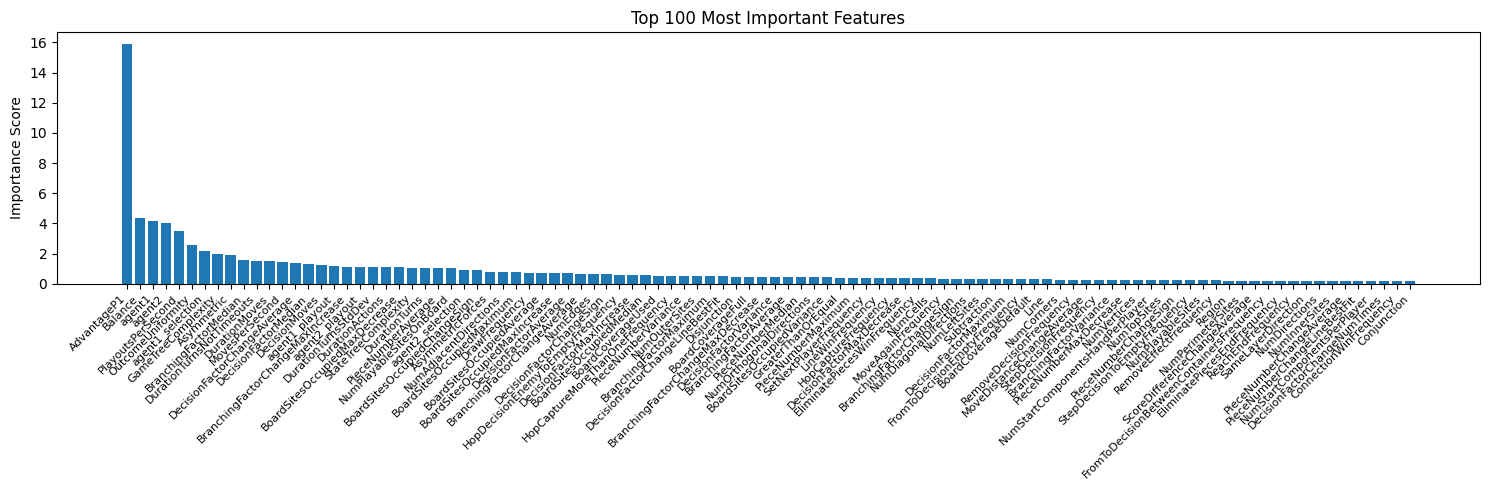

Fold 2 - RMSE: 0.4050633996910597
Fold 3


0:	learn: 0.6104206	test: 0.5725194	best: 0.5725194 (0)	total: 69.2ms	remaining: 3m 27s


50:	learn: 0.3880888	test: 0.4640340	best: 0.4637846 (49)	total: 3.78s	remaining: 3m 38s


100:	learn: 0.3467243	test: 0.4492550	best: 0.4492550 (100)	total: 7.68s	remaining: 3m 40s


150:	learn: 0.3234186	test: 0.4418595	best: 0.4418595 (150)	total: 11.6s	remaining: 3m 38s


200:	learn: 0.3102432	test: 0.4384341	best: 0.4384341 (200)	total: 15.5s	remaining: 3m 35s


250:	learn: 0.2991433	test: 0.4346190	best: 0.4346190 (250)	total: 19.5s	remaining: 3m 33s


300:	learn: 0.2895329	test: 0.4328819	best: 0.4328376 (299)	total: 23.4s	remaining: 3m 29s


350:	learn: 0.2817628	test: 0.4316135	best: 0.4316071 (348)	total: 27.2s	remaining: 3m 25s


400:	learn: 0.2747586	test: 0.4304609	best: 0.4304609 (400)	total: 31.1s	remaining: 3m 21s


450:	learn: 0.2690601	test: 0.4296293	best: 0.4296293 (450)	total: 35s	remaining: 3m 17s


500:	learn: 0.2637016	test: 0.4291012	best: 0.4291012 (500)	total: 39s	remaining: 3m 14s


550:	learn: 0.2589247	test: 0.4282544	best: 0.4281777 (544)	total: 43s	remaining: 3m 10s


600:	learn: 0.2542028	test: 0.4279046	best: 0.4278879 (598)	total: 46.9s	remaining: 3m 7s


650:	learn: 0.2499419	test: 0.4273344	best: 0.4273344 (650)	total: 50.8s	remaining: 3m 3s


700:	learn: 0.2459401	test: 0.4267295	best: 0.4267295 (700)	total: 54.7s	remaining: 2m 59s


750:	learn: 0.2423873	test: 0.4263890	best: 0.4263539 (747)	total: 58.6s	remaining: 2m 55s


800:	learn: 0.2392987	test: 0.4262183	best: 0.4262183 (800)	total: 1m 2s	remaining: 2m 51s


850:	learn: 0.2361566	test: 0.4259601	best: 0.4259601 (850)	total: 1m 6s	remaining: 2m 47s


900:	learn: 0.2332940	test: 0.4254208	best: 0.4254208 (900)	total: 1m 10s	remaining: 2m 44s


950:	learn: 0.2305088	test: 0.4251699	best: 0.4251653 (948)	total: 1m 14s	remaining: 2m 40s


1000:	learn: 0.2277998	test: 0.4248273	best: 0.4248273 (1000)	total: 1m 18s	remaining: 2m 36s


1050:	learn: 0.2253409	test: 0.4246012	best: 0.4246012 (1050)	total: 1m 22s	remaining: 2m 32s


1100:	learn: 0.2228466	test: 0.4243839	best: 0.4243839 (1100)	total: 1m 26s	remaining: 2m 28s


1150:	learn: 0.2205061	test: 0.4242184	best: 0.4242128 (1148)	total: 1m 30s	remaining: 2m 24s


1200:	learn: 0.2181194	test: 0.4240764	best: 0.4240595 (1196)	total: 1m 34s	remaining: 2m 20s


1250:	learn: 0.2159476	test: 0.4240132	best: 0.4240132 (1250)	total: 1m 38s	remaining: 2m 17s


1300:	learn: 0.2138421	test: 0.4240397	best: 0.4239760 (1270)	total: 1m 41s	remaining: 2m 13s


1350:	learn: 0.2116610	test: 0.4238317	best: 0.4238317 (1350)	total: 1m 45s	remaining: 2m 9s


1400:	learn: 0.2095126	test: 0.4237063	best: 0.4237062 (1398)	total: 1m 49s	remaining: 2m 5s


1450:	learn: 0.2075885	test: 0.4236556	best: 0.4236556 (1450)	total: 1m 53s	remaining: 2m 1s


1500:	learn: 0.2056374	test: 0.4236550	best: 0.4236470 (1462)	total: 1m 57s	remaining: 1m 57s


1550:	learn: 0.2037643	test: 0.4235416	best: 0.4235416 (1550)	total: 2m 1s	remaining: 1m 53s


1600:	learn: 0.2020374	test: 0.4234178	best: 0.4234178 (1600)	total: 2m 5s	remaining: 1m 49s


1650:	learn: 0.2002251	test: 0.4232836	best: 0.4232804 (1649)	total: 2m 9s	remaining: 1m 45s


1700:	learn: 0.1986208	test: 0.4230950	best: 0.4230950 (1700)	total: 2m 13s	remaining: 1m 41s


1750:	learn: 0.1967899	test: 0.4230744	best: 0.4230559 (1746)	total: 2m 17s	remaining: 1m 38s


1800:	learn: 0.1951183	test: 0.4230148	best: 0.4230128 (1784)	total: 2m 21s	remaining: 1m 34s


1850:	learn: 0.1936010	test: 0.4230471	best: 0.4229749 (1834)	total: 2m 25s	remaining: 1m 30s


1900:	learn: 0.1919668	test: 0.4230406	best: 0.4229749 (1834)	total: 2m 29s	remaining: 1m 26s


1950:	learn: 0.1903602	test: 0.4230079	best: 0.4229749 (1834)	total: 2m 33s	remaining: 1m 22s


2000:	learn: 0.1889065	test: 0.4230135	best: 0.4229749 (1834)	total: 2m 37s	remaining: 1m 18s


2050:	learn: 0.1875268	test: 0.4230199	best: 0.4229707 (2030)	total: 2m 41s	remaining: 1m 14s


2100:	learn: 0.1860875	test: 0.4229811	best: 0.4229707 (2030)	total: 2m 45s	remaining: 1m 10s


2150:	learn: 0.1847290	test: 0.4230686	best: 0.4229707 (2030)	total: 2m 49s	remaining: 1m 6s


2200:	learn: 0.1833912	test: 0.4230155	best: 0.4229707 (2030)	total: 2m 53s	remaining: 1m 2s


2250:	learn: 0.1820099	test: 0.4228980	best: 0.4228809 (2242)	total: 2m 57s	remaining: 58.9s


2300:	learn: 0.1807393	test: 0.4229108	best: 0.4228603 (2270)	total: 3m 1s	remaining: 55s


2350:	learn: 0.1793511	test: 0.4229284	best: 0.4228603 (2270)	total: 3m 4s	remaining: 51s


2400:	learn: 0.1780674	test: 0.4229174	best: 0.4228603 (2270)	total: 3m 8s	remaining: 47.1s


2450:	learn: 0.1768453	test: 0.4230285	best: 0.4228603 (2270)	total: 3m 12s	remaining: 43.2s


2500:	learn: 0.1756706	test: 0.4229718	best: 0.4228603 (2270)	total: 3m 16s	remaining: 39.3s


2550:	learn: 0.1745053	test: 0.4229054	best: 0.4228603 (2270)	total: 3m 20s	remaining: 35.3s


2600:	learn: 0.1732160	test: 0.4228841	best: 0.4228603 (2270)	total: 3m 24s	remaining: 31.4s


2650:	learn: 0.1719559	test: 0.4228436	best: 0.4228360 (2643)	total: 3m 28s	remaining: 27.5s


2700:	learn: 0.1708374	test: 0.4228679	best: 0.4228360 (2643)	total: 3m 32s	remaining: 23.5s


2750:	learn: 0.1697508	test: 0.4228487	best: 0.4228360 (2643)	total: 3m 36s	remaining: 19.6s


2800:	learn: 0.1685445	test: 0.4229029	best: 0.4228360 (2643)	total: 3m 40s	remaining: 15.7s


2850:	learn: 0.1673139	test: 0.4228933	best: 0.4228360 (2643)	total: 3m 44s	remaining: 11.7s


2900:	learn: 0.1662033	test: 0.4228493	best: 0.4228360 (2643)	total: 3m 48s	remaining: 7.79s


2950:	learn: 0.1651601	test: 0.4228814	best: 0.4228360 (2643)	total: 3m 52s	remaining: 3.86s


2999:	learn: 0.1641909	test: 0.4228373	best: 0.4228318 (2998)	total: 3m 56s	remaining: 0us

bestTest = 0.4228317819
bestIteration = 2998

Shrink model to first 2999 iterations.


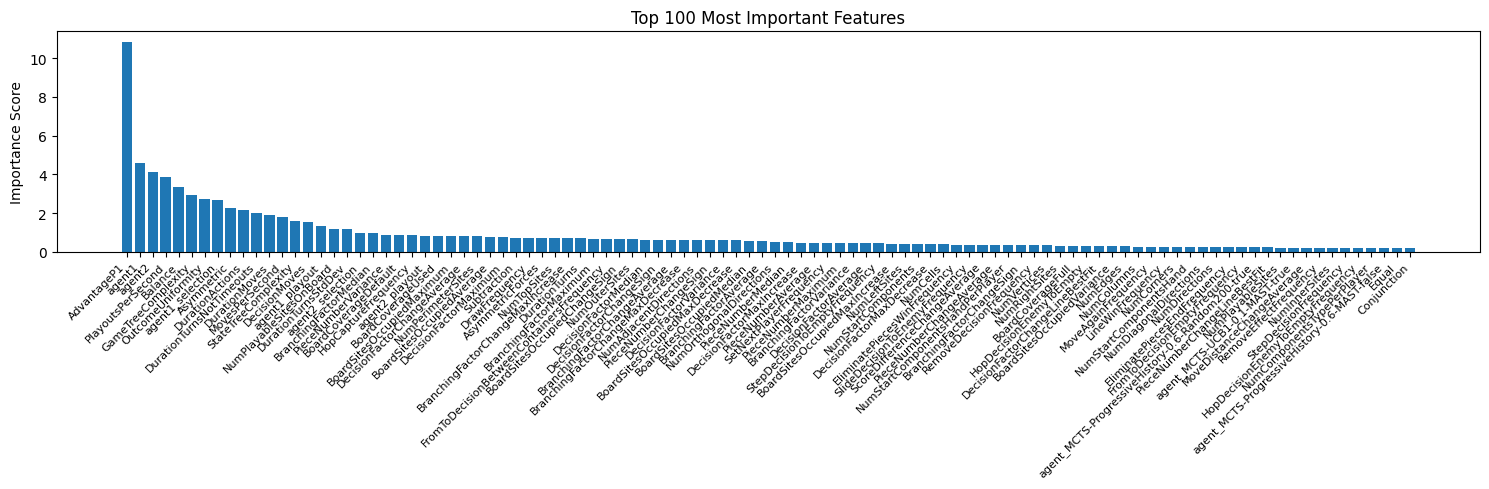

Fold 3 - RMSE: 0.42239728583872693
Fold 4


0:	learn: 0.6098891	test: 0.5656146	best: 0.5656146 (0)	total: 68.9ms	remaining: 3m 26s


50:	learn: 0.3892123	test: 0.4564454	best: 0.4564454 (50)	total: 3.74s	remaining: 3m 36s


100:	learn: 0.3486202	test: 0.4390563	best: 0.4390563 (100)	total: 7.54s	remaining: 3m 36s


150:	learn: 0.3261711	test: 0.4319149	best: 0.4319149 (150)	total: 11.3s	remaining: 3m 33s


200:	learn: 0.3120888	test: 0.4276819	best: 0.4276819 (200)	total: 15.2s	remaining: 3m 31s


250:	learn: 0.3007937	test: 0.4248861	best: 0.4248535 (248)	total: 19s	remaining: 3m 28s


300:	learn: 0.2919321	test: 0.4240841	best: 0.4240766 (299)	total: 22.9s	remaining: 3m 25s


350:	learn: 0.2840119	test: 0.4234634	best: 0.4234634 (350)	total: 26.7s	remaining: 3m 21s


400:	learn: 0.2771363	test: 0.4225770	best: 0.4225599 (399)	total: 30.6s	remaining: 3m 18s


450:	learn: 0.2714559	test: 0.4216666	best: 0.4216605 (446)	total: 34.5s	remaining: 3m 14s


500:	learn: 0.2657959	test: 0.4201194	best: 0.4201194 (500)	total: 38.4s	remaining: 3m 11s


550:	learn: 0.2608355	test: 0.4195440	best: 0.4195440 (550)	total: 42.4s	remaining: 3m 8s


600:	learn: 0.2562431	test: 0.4187811	best: 0.4187811 (600)	total: 46.3s	remaining: 3m 5s


650:	learn: 0.2518371	test: 0.4183234	best: 0.4183234 (650)	total: 50.3s	remaining: 3m 1s


700:	learn: 0.2479380	test: 0.4179736	best: 0.4179736 (700)	total: 54.3s	remaining: 2m 58s


750:	learn: 0.2441958	test: 0.4174906	best: 0.4174336 (744)	total: 58.3s	remaining: 2m 54s


800:	learn: 0.2409683	test: 0.4173393	best: 0.4173393 (800)	total: 1m 2s	remaining: 2m 50s


850:	learn: 0.2376728	test: 0.4170933	best: 0.4170933 (850)	total: 1m 6s	remaining: 2m 46s


900:	learn: 0.2349130	test: 0.4168821	best: 0.4168821 (900)	total: 1m 10s	remaining: 2m 43s


950:	learn: 0.2320865	test: 0.4168617	best: 0.4167676 (929)	total: 1m 13s	remaining: 2m 39s


1000:	learn: 0.2295663	test: 0.4167577	best: 0.4167289 (969)	total: 1m 17s	remaining: 2m 35s


1050:	learn: 0.2270899	test: 0.4164073	best: 0.4164047 (1049)	total: 1m 21s	remaining: 2m 31s


1100:	learn: 0.2247490	test: 0.4162463	best: 0.4162463 (1100)	total: 1m 25s	remaining: 2m 28s


1150:	learn: 0.2222988	test: 0.4161757	best: 0.4161572 (1140)	total: 1m 29s	remaining: 2m 24s


1200:	learn: 0.2200397	test: 0.4160687	best: 0.4160433 (1195)	total: 1m 33s	remaining: 2m 20s


1250:	learn: 0.2178863	test: 0.4159577	best: 0.4159577 (1250)	total: 1m 37s	remaining: 2m 16s


1300:	learn: 0.2157004	test: 0.4159764	best: 0.4159395 (1254)	total: 1m 41s	remaining: 2m 12s


1350:	learn: 0.2136760	test: 0.4158727	best: 0.4158405 (1344)	total: 1m 45s	remaining: 2m 8s


1400:	learn: 0.2115988	test: 0.4158374	best: 0.4158325 (1393)	total: 1m 49s	remaining: 2m 4s


1450:	learn: 0.2096610	test: 0.4156462	best: 0.4156376 (1445)	total: 1m 53s	remaining: 2m 1s


1500:	learn: 0.2078091	test: 0.4155141	best: 0.4155137 (1490)	total: 1m 57s	remaining: 1m 57s


1550:	learn: 0.2060328	test: 0.4155081	best: 0.4154540 (1516)	total: 2m 1s	remaining: 1m 53s


1600:	learn: 0.2042697	test: 0.4154622	best: 0.4154537 (1597)	total: 2m 5s	remaining: 1m 49s


1650:	learn: 0.2026030	test: 0.4154578	best: 0.4154207 (1609)	total: 2m 9s	remaining: 1m 45s


1700:	learn: 0.2008888	test: 0.4154554	best: 0.4154207 (1609)	total: 2m 13s	remaining: 1m 41s


1750:	learn: 0.1993472	test: 0.4154353	best: 0.4154035 (1725)	total: 2m 17s	remaining: 1m 37s


1800:	learn: 0.1976708	test: 0.4153271	best: 0.4153271 (1800)	total: 2m 21s	remaining: 1m 33s


1850:	learn: 0.1962320	test: 0.4153660	best: 0.4152760 (1824)	total: 2m 25s	remaining: 1m 30s


1900:	learn: 0.1948837	test: 0.4153925	best: 0.4152760 (1824)	total: 2m 29s	remaining: 1m 26s


1950:	learn: 0.1933934	test: 0.4153257	best: 0.4152760 (1824)	total: 2m 33s	remaining: 1m 22s


2000:	learn: 0.1918855	test: 0.4153702	best: 0.4152760 (1824)	total: 2m 37s	remaining: 1m 18s


2050:	learn: 0.1905429	test: 0.4152951	best: 0.4152760 (1824)	total: 2m 40s	remaining: 1m 14s


2100:	learn: 0.1891576	test: 0.4153199	best: 0.4152760 (1824)	total: 2m 44s	remaining: 1m 10s


2150:	learn: 0.1878839	test: 0.4152463	best: 0.4152307 (2139)	total: 2m 48s	remaining: 1m 6s


2200:	learn: 0.1866106	test: 0.4152273	best: 0.4152273 (2200)	total: 2m 52s	remaining: 1m 2s


2250:	learn: 0.1853516	test: 0.4151906	best: 0.4151397 (2231)	total: 2m 56s	remaining: 58.8s


2300:	learn: 0.1842322	test: 0.4151434	best: 0.4151397 (2231)	total: 3m	remaining: 55s


2350:	learn: 0.1827460	test: 0.4151671	best: 0.4151358 (2302)	total: 3m 4s	remaining: 51s


2400:	learn: 0.1815606	test: 0.4151382	best: 0.4151358 (2302)	total: 3m 8s	remaining: 47.1s


2450:	learn: 0.1803322	test: 0.4150932	best: 0.4150884 (2415)	total: 3m 12s	remaining: 43.2s


2500:	learn: 0.1789802	test: 0.4151177	best: 0.4150863 (2464)	total: 3m 16s	remaining: 39.3s


2550:	learn: 0.1777398	test: 0.4151037	best: 0.4150863 (2464)	total: 3m 20s	remaining: 35.3s


2600:	learn: 0.1766360	test: 0.4151145	best: 0.4150863 (2464)	total: 3m 24s	remaining: 31.4s


2650:	learn: 0.1755549	test: 0.4150653	best: 0.4150586 (2649)	total: 3m 28s	remaining: 27.5s


2700:	learn: 0.1744333	test: 0.4150119	best: 0.4150109 (2699)	total: 3m 32s	remaining: 23.6s


2750:	learn: 0.1733240	test: 0.4150537	best: 0.4150088 (2701)	total: 3m 36s	remaining: 19.6s


2800:	learn: 0.1722048	test: 0.4149978	best: 0.4149964 (2788)	total: 3m 41s	remaining: 15.7s


2850:	learn: 0.1711251	test: 0.4150398	best: 0.4149869 (2804)	total: 3m 45s	remaining: 11.8s


2900:	learn: 0.1700422	test: 0.4150442	best: 0.4149869 (2804)	total: 3m 49s	remaining: 7.82s


2950:	learn: 0.1688557	test: 0.4150815	best: 0.4149869 (2804)	total: 3m 53s	remaining: 3.87s


2999:	learn: 0.1678196	test: 0.4150558	best: 0.4149869 (2804)	total: 3m 56s	remaining: 0us

bestTest = 0.41498691
bestIteration = 2804

Shrink model to first 2805 iterations.


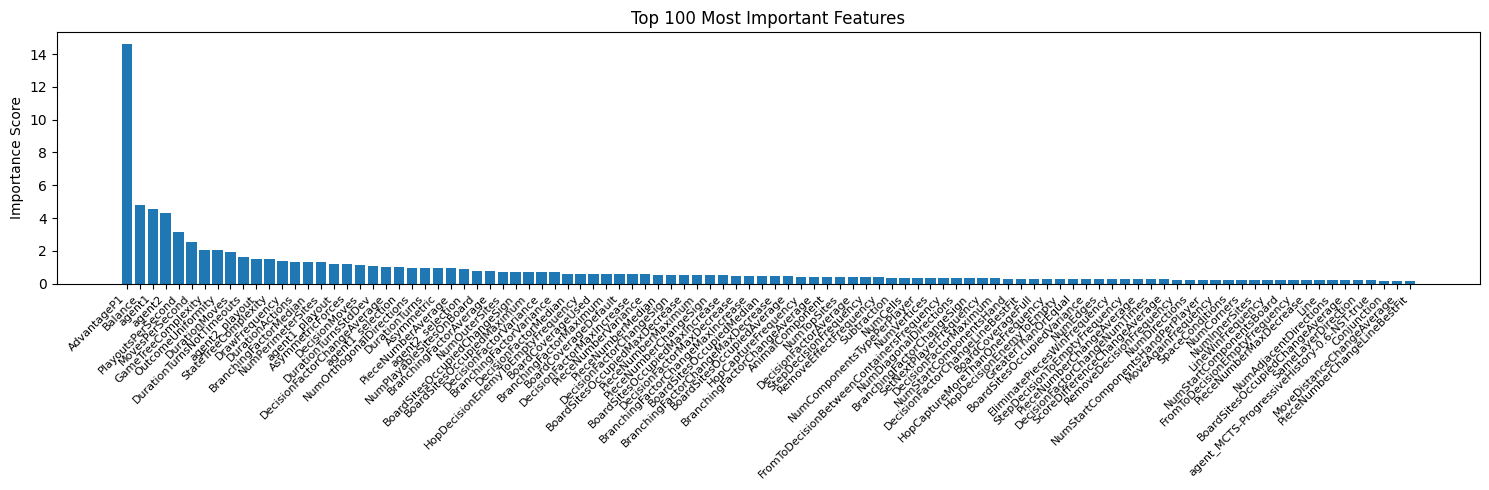

Fold 4 - RMSE: 0.4141710893350548
Fold 5


0:	learn: 0.6055572	test: 0.5802803	best: 0.5802803 (0)	total: 64.8ms	remaining: 3m 14s


50:	learn: 0.3878333	test: 0.4738835	best: 0.4736226 (49)	total: 3.88s	remaining: 3m 44s


100:	learn: 0.3486902	test: 0.4540864	best: 0.4540790 (99)	total: 7.88s	remaining: 3m 46s


150:	learn: 0.3273835	test: 0.4466399	best: 0.4466360 (149)	total: 11.8s	remaining: 3m 43s


200:	learn: 0.3118989	test: 0.4423337	best: 0.4423337 (200)	total: 15.8s	remaining: 3m 39s


250:	learn: 0.3010552	test: 0.4391804	best: 0.4391804 (250)	total: 19.7s	remaining: 3m 36s


300:	learn: 0.2921386	test: 0.4373386	best: 0.4373386 (300)	total: 23.7s	remaining: 3m 32s


350:	learn: 0.2847869	test: 0.4362365	best: 0.4362041 (349)	total: 27.7s	remaining: 3m 29s


400:	learn: 0.2780187	test: 0.4353201	best: 0.4353201 (400)	total: 31.7s	remaining: 3m 25s


450:	learn: 0.2720338	test: 0.4340428	best: 0.4340428 (450)	total: 35.8s	remaining: 3m 22s


500:	learn: 0.2668051	test: 0.4334000	best: 0.4334000 (500)	total: 39.9s	remaining: 3m 18s


550:	learn: 0.2617213	test: 0.4328886	best: 0.4328295 (541)	total: 43.8s	remaining: 3m 14s


600:	learn: 0.2571934	test: 0.4324832	best: 0.4324142 (587)	total: 47.9s	remaining: 3m 11s


650:	learn: 0.2532539	test: 0.4320129	best: 0.4319946 (648)	total: 52s	remaining: 3m 7s


700:	learn: 0.2495295	test: 0.4312116	best: 0.4312116 (700)	total: 56s	remaining: 3m 3s


750:	learn: 0.2461868	test: 0.4308767	best: 0.4308767 (750)	total: 60s	remaining: 2m 59s


800:	learn: 0.2426347	test: 0.4303755	best: 0.4303755 (800)	total: 1m 4s	remaining: 2m 55s


850:	learn: 0.2395070	test: 0.4300613	best: 0.4300104 (845)	total: 1m 8s	remaining: 2m 51s


900:	learn: 0.2363292	test: 0.4299136	best: 0.4299002 (898)	total: 1m 12s	remaining: 2m 47s


950:	learn: 0.2335509	test: 0.4295685	best: 0.4295282 (943)	total: 1m 16s	remaining: 2m 44s


1000:	learn: 0.2307975	test: 0.4294033	best: 0.4293573 (994)	total: 1m 20s	remaining: 2m 40s


1050:	learn: 0.2280626	test: 0.4290205	best: 0.4290205 (1050)	total: 1m 24s	remaining: 2m 35s


1100:	learn: 0.2257160	test: 0.4286755	best: 0.4286755 (1100)	total: 1m 28s	remaining: 2m 32s


1150:	learn: 0.2233472	test: 0.4284305	best: 0.4284305 (1150)	total: 1m 32s	remaining: 2m 28s


1200:	learn: 0.2211438	test: 0.4281700	best: 0.4281700 (1200)	total: 1m 36s	remaining: 2m 24s


1250:	learn: 0.2190236	test: 0.4279458	best: 0.4279458 (1250)	total: 1m 40s	remaining: 2m 20s


1300:	learn: 0.2167847	test: 0.4277662	best: 0.4277514 (1295)	total: 1m 44s	remaining: 2m 16s


1350:	learn: 0.2147478	test: 0.4278081	best: 0.4276954 (1307)	total: 1m 48s	remaining: 2m 12s


1400:	learn: 0.2127999	test: 0.4278878	best: 0.4276954 (1307)	total: 1m 52s	remaining: 2m 8s


1450:	learn: 0.2109904	test: 0.4278205	best: 0.4276954 (1307)	total: 1m 56s	remaining: 2m 4s


1500:	learn: 0.2089952	test: 0.4276816	best: 0.4276816 (1500)	total: 2m	remaining: 2m


1550:	learn: 0.2070731	test: 0.4276649	best: 0.4276303 (1530)	total: 2m 4s	remaining: 1m 56s


1600:	learn: 0.2053957	test: 0.4276215	best: 0.4275563 (1590)	total: 2m 8s	remaining: 1m 52s


1650:	learn: 0.2037390	test: 0.4276889	best: 0.4275563 (1590)	total: 2m 12s	remaining: 1m 48s


1700:	learn: 0.2021261	test: 0.4276623	best: 0.4275563 (1590)	total: 2m 17s	remaining: 1m 44s


1750:	learn: 0.2005468	test: 0.4276419	best: 0.4275208 (1722)	total: 2m 21s	remaining: 1m 40s


1800:	learn: 0.1988636	test: 0.4276218	best: 0.4275208 (1722)	total: 2m 25s	remaining: 1m 36s


1850:	learn: 0.1973893	test: 0.4276380	best: 0.4275208 (1722)	total: 2m 29s	remaining: 1m 32s


1900:	learn: 0.1958509	test: 0.4276211	best: 0.4275208 (1722)	total: 2m 33s	remaining: 1m 28s


1950:	learn: 0.1943032	test: 0.4275156	best: 0.4275099 (1948)	total: 2m 37s	remaining: 1m 24s


2000:	learn: 0.1930097	test: 0.4275659	best: 0.4275064 (1953)	total: 2m 41s	remaining: 1m 20s


2050:	learn: 0.1916102	test: 0.4275477	best: 0.4275064 (1953)	total: 2m 45s	remaining: 1m 16s


2100:	learn: 0.1903332	test: 0.4274961	best: 0.4274961 (2100)	total: 2m 49s	remaining: 1m 12s


2150:	learn: 0.1889506	test: 0.4273582	best: 0.4273573 (2149)	total: 2m 53s	remaining: 1m 8s


2200:	learn: 0.1875250	test: 0.4273322	best: 0.4273300 (2199)	total: 2m 57s	remaining: 1m 4s


2250:	learn: 0.1862112	test: 0.4273981	best: 0.4273263 (2206)	total: 3m 1s	remaining: 1m


2300:	learn: 0.1848392	test: 0.4273681	best: 0.4273263 (2206)	total: 3m 5s	remaining: 56.4s


2350:	learn: 0.1835852	test: 0.4274036	best: 0.4273263 (2206)	total: 3m 9s	remaining: 52.4s


2400:	learn: 0.1822956	test: 0.4274302	best: 0.4273263 (2206)	total: 3m 13s	remaining: 48.4s


2450:	learn: 0.1810820	test: 0.4273879	best: 0.4273263 (2206)	total: 3m 17s	remaining: 44.3s


2500:	learn: 0.1798820	test: 0.4273610	best: 0.4273263 (2206)	total: 3m 21s	remaining: 40.3s


2550:	learn: 0.1786571	test: 0.4273326	best: 0.4273109 (2533)	total: 3m 25s	remaining: 36.3s


2600:	learn: 0.1775157	test: 0.4273008	best: 0.4272868 (2576)	total: 3m 30s	remaining: 32.2s


2650:	learn: 0.1763017	test: 0.4272963	best: 0.4272852 (2607)	total: 3m 34s	remaining: 28.2s


2700:	learn: 0.1750681	test: 0.4273321	best: 0.4272669 (2663)	total: 3m 38s	remaining: 24.1s


2750:	learn: 0.1740373	test: 0.4273525	best: 0.4272669 (2663)	total: 3m 42s	remaining: 20.1s


2800:	learn: 0.1728571	test: 0.4273491	best: 0.4272669 (2663)	total: 3m 46s	remaining: 16.1s


2850:	learn: 0.1718238	test: 0.4274081	best: 0.4272669 (2663)	total: 3m 50s	remaining: 12s


2900:	learn: 0.1706784	test: 0.4273528	best: 0.4272669 (2663)	total: 3m 54s	remaining: 7.99s


2950:	learn: 0.1696835	test: 0.4273150	best: 0.4272669 (2663)	total: 3m 58s	remaining: 3.96s


2999:	learn: 0.1686986	test: 0.4273530	best: 0.4272669 (2663)	total: 4m 2s	remaining: 0us

bestTest = 0.4272668672
bestIteration = 2663

Shrink model to first 2664 iterations.


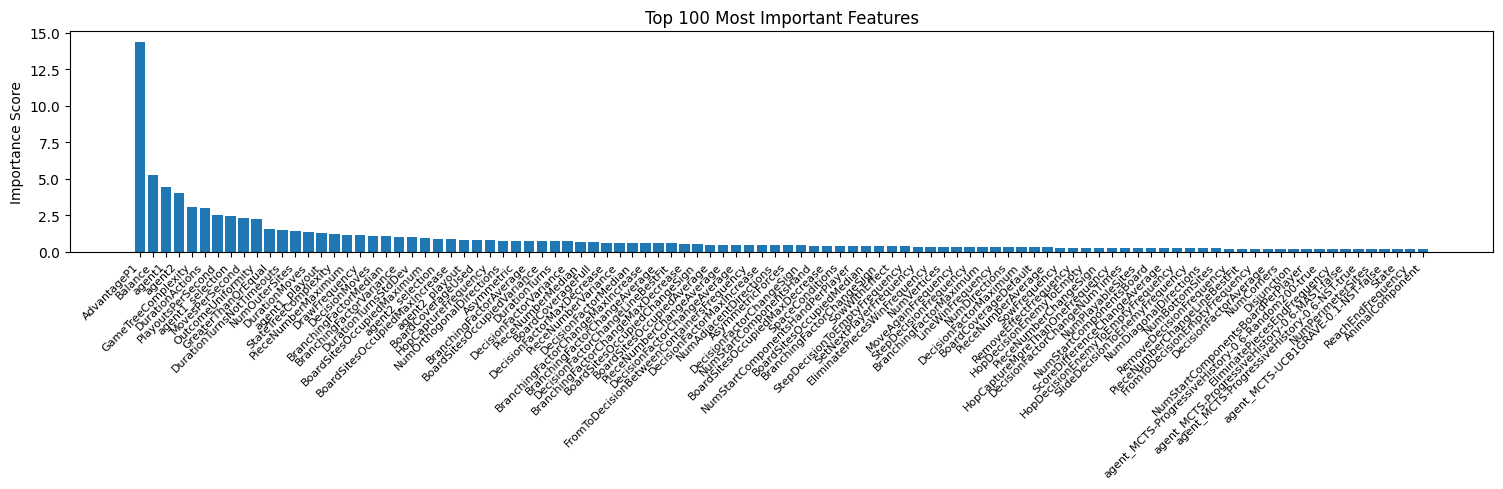

Fold 5 - RMSE: 0.4266909786108974
List of oof scores: [0.4313805944744417, 0.4050633996910597, 0.42239728583872693, 0.4141710893350548, 0.4266909786108974]
Average oof score: 0.4199406695900361


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4168
Score: 0.4502
Score: 0.4308
Score: 0.4373
Score: 0.3997
Average CV1 Score: 0.4270

CV2 OOF Scores:
Score: 0.4035
Score: 0.3977
Score: 0.4244
Score: 0.4422
Score: 0.4357
Average CV2 Score: 0.4207

CV3 OOF Scores:
Score: 0.4314
Score: 0.4051
Score: 0.4224
Score: 0.4142
Score: 0.4267
Average CV3 Score: 0.4199


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

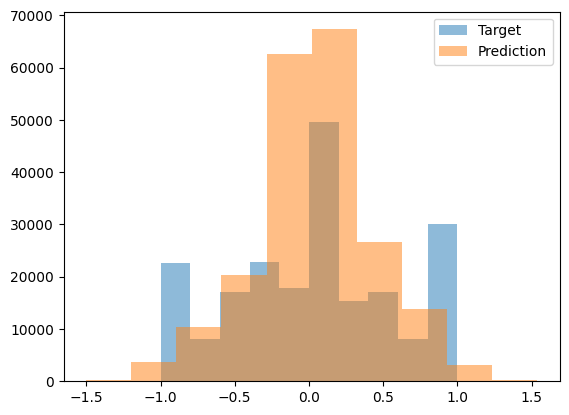

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.15394        │
│ 233235 ┆ -0.169385      │
│ 233236 ┆ 0.000275       │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***